In [2]:
#Beta-band Bursting
#Arjun Balachandar Oct 2024
#This script is used to analyze the LFP bursting data from the SD patients, comparing SD vs non-SD
#Of note, non-SD is often referred to as oneYear, although patients non-SD recordings could be at anytime in the non-SD period

#Directories and File Names
PATH = #Replace with path for files
lfpDir = PATH + 'data_processed/'
clinVarFile = PATH + 'statusDystonicusDates_NEW.csv'#PATH + 'statusDystonicusDates.csv'
implantDateFile = PATH + 'patientSummary.csv'
optimalChannelsFile = PATH + 'AvailabilitySummary - with optimal channels - deidentified.xlsx'
resultsDir = PATH + 'Analysis/'
resultsLFPPowersDir = resultsDir + 'LFP Powers/'
resultsPSDsDir = resultsDir + 'PSDs/'
resultsPSDPeaksDir = resultsDir + 'PSDPeaks/'
extraSDDatesFile = PATH + 'statusDystonicusDates_EXTRADATES.csv'
burstingresultsFilename = 'burstingAfterStatusDystonicus.csv'
resultsFilename = 'powerChangesAfterCuringStatusDystonicus.csv'
resultsPSDFilename = 'PSDsAfterCuringStatusDystonicus.csv'
resultsCohDir = resultsDir + 'Coherence/'
resultsCohFilename = 'coherenceAfterCuringStatusDystonicus.csv'

#Frequency bands
betaLim = [12.5, 30] # In Hertz, define the beta band
thetaLim = [3, 7] # 3.5-7 as per Mark, Was [4,7] before 31 Jan
deltaLim = [1,3]
alphaLim = [7,12.5]
gammaLim = [30,60]
lowbetaLim = [12.5, 20]
highbetaLim = [20, 30]
lowgammaLim = [30, 40]
highgammaLim = [40, 60]
channelOverride = False # True # Should be false. Set to true if you want to set the channel manually (not recommended).
z_score_norm = False #Normalize the LFP values by z-scoring normalization if True
normalize_PSD = True #Normalize the PSD values by dividing by sum of total power of PSD

# Initializations
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import signal
from scipy.signal import welch
import matplotlib.pyplot as plt
import scipy.stats as stats
import re #regular expression
import neurodsp
from neurodsp.utils.norm import normalize_sig
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure
from sklearn.preprocessing import StandardScaler
import itertools

diff = lambda x, y: y - x

# Load and process the dates
clinVars_df = pd.read_csv(clinVarFile, delimiter=',')
implantDates_df = pd.read_csv(implantDateFile, delimiter=',')
extraSDDates_df = pd.read_csv(extraSDDatesFile, delimiter=',')
patList = clinVars_df['Subject ID'].values
#patList = ['DBS005']
results = pd.DataFrame() #Final output of LFP power values, divided into spectra
results_PSD = pd.DataFrame() #Final output of PSDs for each patient at each time point

plt.rcParams['figure.dpi'] = 600

patList

array(['DBS003', 'DBS005', 'DBS013', 'DBS014', 'DBS018', 'DBS021',
       'DBS036', 'DBS047', 'DBS050', 'DBS039'], dtype=object)

In [3]:
def getWelch(theSig,fs):
    mid50lim = np.percentile(theSig, [25, 75])     # Keeps the middle 50% - not winsorizes
    data_mid50 = [x for x in theSig if x >= mid50lim[0] and x <= mid50lim[1]]
    std_mid50 = np.std(data_mid50) # standard deviation of the middle 50% of data
    theSig = [x for x in theSig if x >= mid50lim[0] - 5*std_mid50 and x <= mid50lim[1] + 5*std_mid50] # Throws away data that is more than 5 standard deviations from the extrema of the middle 50% of data
    #theSig = np.convolve(theSig, np.ones(5)/5, mode='same') # Artefacts tend to last a while, so median filter not appropriate
    #theSig = stats.mstats.winsorize(np.array(theSig), limits=[0.05, 0.05])
    #print('Processing channel', channel, 'for patient', subjID, 'in', intervalType, 'segment from', segment[0], 'for',duration,'seconds')
    freqs, psd = welch(theSig, fs=fs, nperseg=256) # Calculate spectral power using Welch method
    return freqs, psd,data_mid50,std_mid50

Processing patient DBS003 .
Processing patient DBS005 .
Processing patient DBS013 .
Processing patient DBS014 .
Processing patient DBS018 .
Processing patient DBS021 .
Processing patient DBS036 .
Processing patient DBS047 .
Processing patient DBS050 .
Processing patient DBS039 .
15-second segment of DBS036's beta-band signal and Hilbert envelope saved to /Users/arjunbalachandar/Desktop/University of Toronto/Research/Ibrahim Lab/Dystonia Project/Analysis/DBS036_15s_BetaBand_Envelope.csv


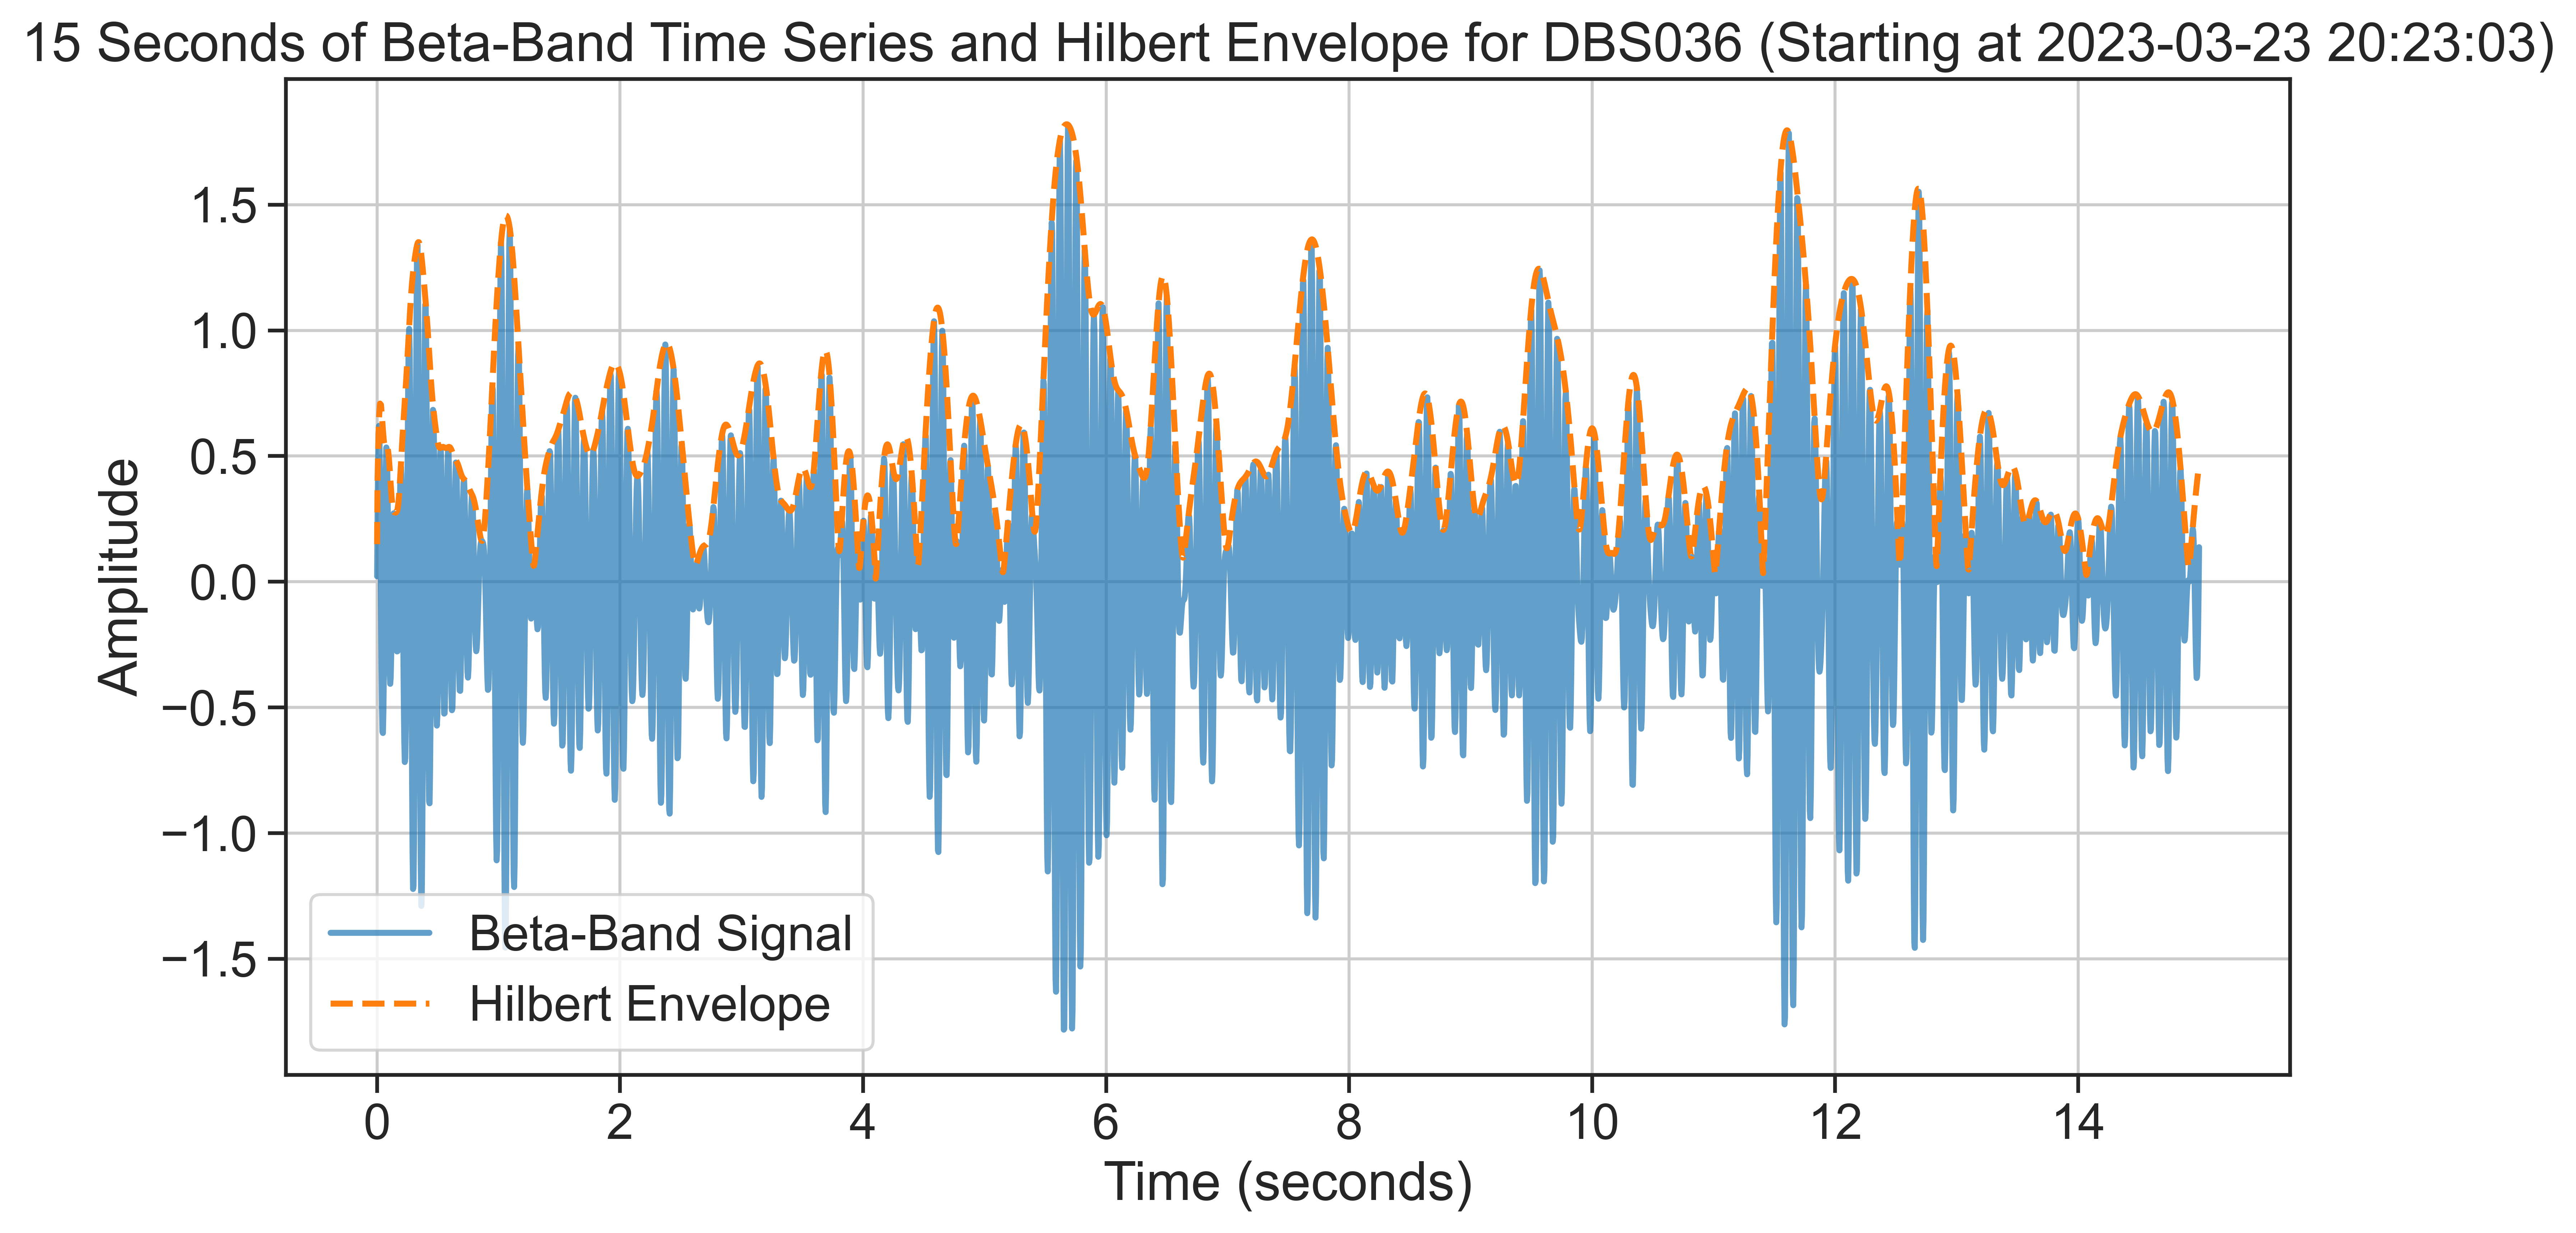

All patients' beta burst results saved to /Users/arjunbalachandar/Desktop/University of Toronto/Research/Ibrahim Lab/Dystonia Project/Analysis/All_Patients_BetaBurst_Results.csv


In [13]:
#BURSTING CALCULATION

from scipy.signal import butter, filtfilt, hilbert
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os

burst_threshold = 75 #can set to 75%, 60% etc

# Define the optimal channels for each patient
def get_hemisphere_channels(patient, channel):
    # Extract hemisphere from the channel name
    if channel.endswith('_RIGHT'):
        hemisphere_channel = 'RIGHT'
    elif channel.endswith('_LEFT'):
        hemisphere_channel = 'LEFT'
    else:
        return None  # Return None if it's not a valid channel
    
    # Return optimal channels based on the patient and hemisphere
    if patient == 'DBS036' and hemisphere_channel == 'LEFT':
        return ['ZERO_THREE']
    if patient == 'DBS009' and hemisphere_channel == 'RIGHT':
        return ['ZERO_THREE']
    if patient == 'DBS014' and hemisphere_channel == 'LEFT':
        return ['ZERO_TWO']
    if patient == 'DBS013' and hemisphere_channel == 'RIGHT':
        return ['ONE_THREE']
    if patient == 'DBS021' and hemisphere_channel == 'LEFT':
        return ['ZERO_TWO']
    if patient == 'DBS021' and hemisphere_channel == 'RIGHT':
        return ['ZERO_TWO']
    if patient == 'DBS005' and hemisphere_channel == 'LEFT':
        return ['ONE_THREE']
    if patient == 'DBS005' and hemisphere_channel == 'RIGHT':
        return ['TWO_THREE']
    if patient == 'DBS047' and hemisphere_channel == 'LEFT':
        return ['ZERO_TWO']
    if patient == 'DBS047' and hemisphere_channel == 'RIGHT':
        return ['ZERO_TWO']
    if patient == 'DBS050' and hemisphere_channel == 'LEFT':
        return ['ZERO_TWO']
    if patient == 'DBS039' and hemisphere_channel == 'LEFT':
        return ['ONE_THREE']
    return ['ONE_THREE']

def get_optimal_hemisphere(patient): #function returns the optimal hemisphere for a patient, so only PSD from the optimal hemisphere will be used for ML
    if patient == 'DBS003':
        return 'RIGHT'
    if patient == 'DBS005':
        return 'RIGHT'
    if patient == 'DBS013':
        return 'RIGHT'
    if patient == 'DBS014':
        return 'LEFT'
    if patient == 'DBS018':
        return 'RIGHT'
    if patient == 'DBS021':
        return 'RIGHT'
    if patient == 'DBS036':
        return 'RIGHT'
    if patient == 'DBS039':
        return 'LEFT'
    if patient == 'DBS047':
        return 'RIGHT'
    if patient == 'DBS050':
        return 'LEFT'
    return 'RIGHT'

# Helper functions (as before)
def bandpass_filter(data, fs, lowcut, highcut):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data)

def compute_hilbert_envelope(data):
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

def calculate_beta_metrics(beta_envelope, segment_duration, fs):
    threshold = np.percentile(beta_envelope, burst_threshold)
    bursts = beta_envelope > threshold

    burst_durations = []
    burst_amplitudes = []
    current_burst = []

    for i, is_burst in enumerate(bursts):
        if is_burst:
            current_burst.append(i)
        elif current_burst:
            burst_duration = len(current_burst) / fs
            if burst_duration >= 0.1:  # Only include bursts >= 100 ms
                burst_durations.append(burst_duration)
                burst_amplitudes.append(max(beta_envelope[current_burst]))  # Max amplitude during burst
            current_burst = []

    total_burst_duration = sum(burst_durations)
    burst_rate = len(burst_durations) / (segment_duration / 60)  # bursts per minute
    burst_duration_percentage = (total_burst_duration / segment_duration) * 100
    avg_burst_amplitude = np.mean(burst_amplitudes) if burst_amplitudes else 0
    avg_burst_duration = np.mean(burst_durations) if burst_durations else 0  # Calculate average burst duration

    return burst_duration_percentage, burst_rate, avg_burst_amplitude, avg_burst_duration, threshold

# Variables to store time series and envelope for DBS036
dbs036_beta_band_series = None
dbs036_hilbert_envelope = None
dbs036_sample_rate = None
dbs036_start_time = None

# DataFrame to store results for all patients and recordings
results = pd.DataFrame()

# Main loop for each patient and recording
for subjID in patList:
    # Load and combine time series data as before
    timeseries_df = pd.read_csv(os.path.join(lfpDir, f'{subjID}_timeseries.csv'), parse_dates=['DateTime (UTC)'], index_col='DateTime (UTC)')
    if subjID in ['DBS005', 'DBS013', 'DBS018', 'DBS021', 'DBS036']:
        file_path_NEW = os.path.join(lfpDir, f'{subjID}_timeseries_NEW1.csv')
        timeseries_NEW_df = pd.read_csv(file_path_NEW, parse_dates=['DateTime (UTC)'], index_col='DateTime (UTC)')
        timeseries_df = pd.concat([timeseries_df, timeseries_NEW_df], axis=0)
        timeseries_df = timeseries_df.loc[~timeseries_df.index.duplicated(keep='first')]

    implantDate = implantDates_df.loc[implantDates_df['Patient ID'] == subjID, 'Implant date'].values[0]
    implantDate = datetime.strptime(implantDate, '%Y-%m-%d')
    
    registry_df = clinVars_df.copy()
    registry_df = registry_df.loc[registry_df['Subject ID'] == subjID]
    if registry_df.empty:
        print('No registry data for patient', subjID)
        continue
    if pd.isna(registry_df['Date of Status dystonicus'].values[0]):
        print('No status dystonicus data for patient', subjID)
        continue
    
    status_date = datetime.strptime(registry_df['Date of Status dystonicus'].values[0], '%d-%b-%y')
    startDate = max(status_date, implantDate)
    one_year_after = startDate + timedelta(days=365)
    discharge_date = datetime.strptime(registry_df['Date of Discharge'].values[0], '%d-%b-%y')
    print('Processing patient', subjID, '.')

    # Extract extra status dystonicus dates
    extra_status_dates_str = extraSDDates_df.loc[extraSDDates_df['Subject ID'] == subjID, 'Date of Extra Status dystonicus'].values
    extra_status_dates = []
    if len(extra_status_dates_str) > 0 and not pd.isna(extra_status_dates_str[0]):
        extra_status_dates = [datetime.strptime(date.strip(), '%Y-%m-%d') for date in extra_status_dates_str[0].split(',')]

    # Filter recordings for status dystonicus (including extra dates)
    early_recordings = timeseries_df.loc[
        (timeseries_df.index >= startDate - timedelta(days=10)) &
        (timeseries_df.index <= startDate + timedelta(days=45))
    ]

    # Include recordings for each extra status date
    for extra_date in extra_status_dates:
        extra_recordings = timeseries_df.loc[
            (timeseries_df.index >= extra_date - timedelta(days=10)) &
            (timeseries_df.index <= extra_date + timedelta(days=45))
        ]
        early_recordings = pd.concat([early_recordings, extra_recordings])
        early_recordings = early_recordings.loc[~early_recordings.index.duplicated(keep='first')]

    # Filter recordings for one year later, explicitly excluding extra status dates
    excluded_dates = [(date - timedelta(days=10), date + timedelta(days=45)) for date in extra_status_dates]
    one_year_recordings = timeseries_df.loc[
        ((timeseries_df.index >= one_year_after - timedelta(days=270)) &
         (timeseries_df.index <= one_year_after + timedelta(days=10000))) |
        (timeseries_df.index < startDate - timedelta(days=15))
    ]

    # Exclude recordings that fall within any extra status dystonicus date range
    for start, end in excluded_dates:
        one_year_recordings = one_year_recordings.loc[
            (one_year_recordings.index < start) | (one_year_recordings.index > end)
        ]


    # For each segment, normalize, calculate PSD, find peak beta frequency, and analyze beta bursts
    for intervalType, recordings in [('status', early_recordings), ('oneYear', one_year_recordings)]:
        if not recordings.empty:
            contiguous_segments = []
            current_segment = []
            for time, data in recordings.iterrows():
                if not current_segment or (time - current_segment[-1] < timedelta(seconds=2)):
                    current_segment.append(time)
                else:
                    contiguous_segments.append(current_segment)
                    current_segment = [time]
            if current_segment:
                contiguous_segments.append(current_segment)

            for segment in contiguous_segments:
                segment_data = recordings.loc[segment[0]:segment[-1]]
                fs = 1 / (segment_data.index[1] - segment_data.index[0]).total_seconds()
                segment_duration = (segment[-1] - segment[0]).total_seconds()

                for channel in segment_data.columns[1:]:
                    optimal_hemisphere_channels = get_hemisphere_channels(subjID, channel) #Only take optimal channel and hemisphere data to use for bursting analysis
                    if channel.endswith('_RIGHT'):
                        hemisphere = 'RIGHT'
                        channel_clean = channel.replace('_RIGHT', '') #just channel, without hemisphere at end
                    elif channel.endswith('_LEFT'):
                        hemisphere = 'LEFT'
                        channel_clean = channel.replace('_LEFT', '') #just channel, without hemisphere at end
                    if channel_clean in optimal_hemisphere_channels and hemisphere == get_optimal_hemisphere(subjID): #If the channel is the optimal channel and optimal hemisphere, get data for bursting
                        channel_data = segment_data[channel].dropna().values
                        if len(channel_data) <= 2:
                            continue

                        # Z-score normalization
                        channel_data = (channel_data - np.mean(channel_data)) / np.std(channel_data)

                        # Calculate PSD
                        freqs, psd, _, _ = getWelch(channel_data, fs=fs)
                        psd /= np.sum(psd)

                        # Find peak frequency in beta-band
                        beta_indices = np.where((freqs >= 12.5) & (freqs <= 30))[0]
                        beta_peak_freq = freqs[beta_indices][np.argmax(psd[beta_indices])]

                        # Bandpass filter around beta peak frequency ±3 Hz
                        lowcut, highcut = beta_peak_freq - 3, beta_peak_freq + 3
                        beta_band_data = bandpass_filter(channel_data, fs, lowcut, highcut)

                        # Compute beta envelope
                        beta_envelope = compute_hilbert_envelope(beta_band_data)

                        # Calculate beta metrics
                        burst_duration_percentage, burst_rate, avg_burst_amplitude, avg_burst_duration, threshold = calculate_beta_metrics(beta_envelope, segment_duration, fs)

                        # Store results in DataFrame
                        resultRow = pd.DataFrame({
                            'Patient': [subjID],
                            'IntervalType': [intervalType],
                            'RecordingStartTime': [segment[0].strftime('%Y-%m-%d %H:%M:%S')],
                            'Channel': [channel],
                            'BetaPeakFrequency': [beta_peak_freq],
                            'BurstDurationPercentage': [burst_duration_percentage],
                            'BurstRate': [burst_rate],
                            'AvgBurstAmplitude': [avg_burst_amplitude],
                            'AvgBurstDuration': [avg_burst_duration]
                        })
                        results = pd.concat([results, resultRow], ignore_index=True)

                        # Store 15 seconds of filtered beta-band time series and envelope for DBS036
                        if subjID == 'DBS036' and dbs036_beta_band_series is None:
                            sample_start = 0
                            sample_end = min(int(15 * fs), len(beta_band_data))  # 15 seconds or less if shorter
                            dbs036_beta_band_series = beta_band_data[sample_start:sample_end]
                            dbs036_hilbert_envelope = beta_envelope[sample_start:sample_end]
                            dbs036_sample_rate = fs
                            dbs036_start_time = segment[0]
                            dbs036_threshold = threshold #store threshold for plotting

# Save 15-second segment for DBS036
if dbs036_beta_band_series is not None and dbs036_hilbert_envelope is not None:
    dbs036_df = pd.DataFrame({
        'Time (s)': np.arange(len(dbs036_beta_band_series)) / dbs036_sample_rate,
        'Beta-Band Signal': dbs036_beta_band_series,
        'Hilbert Envelope': dbs036_hilbert_envelope,
        'Threshold':dbs036_threshold
    })

    output_filepath = os.path.join(resultsDir, 'DBS036_15s_BetaBand_Envelope.csv')
    dbs036_df.to_csv(output_filepath, index=False)
    print(f"15-second segment of DBS036's beta-band signal and Hilbert envelope saved to {output_filepath}")

    # Plotting the beta-band-filtered time series and Hilbert envelope
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(dbs036_df['Time (s)'], dbs036_df['Beta-Band Signal'], label='Beta-Band Signal', alpha=0.7)
    plt.plot(dbs036_df['Time (s)'], dbs036_df['Hilbert Envelope'], label='Hilbert Envelope', linestyle='--')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'15 Seconds of Beta-Band Time Series and Hilbert Envelope for DBS036 (Starting at {dbs036_start_time})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save all results to CSV
results_filepath = os.path.join(resultsDir, 'All_Patients_BetaBurst_Results.csv')
results.to_csv(results_filepath, index=False)
print(f"All patients' beta burst results saved to {results_filepath}")


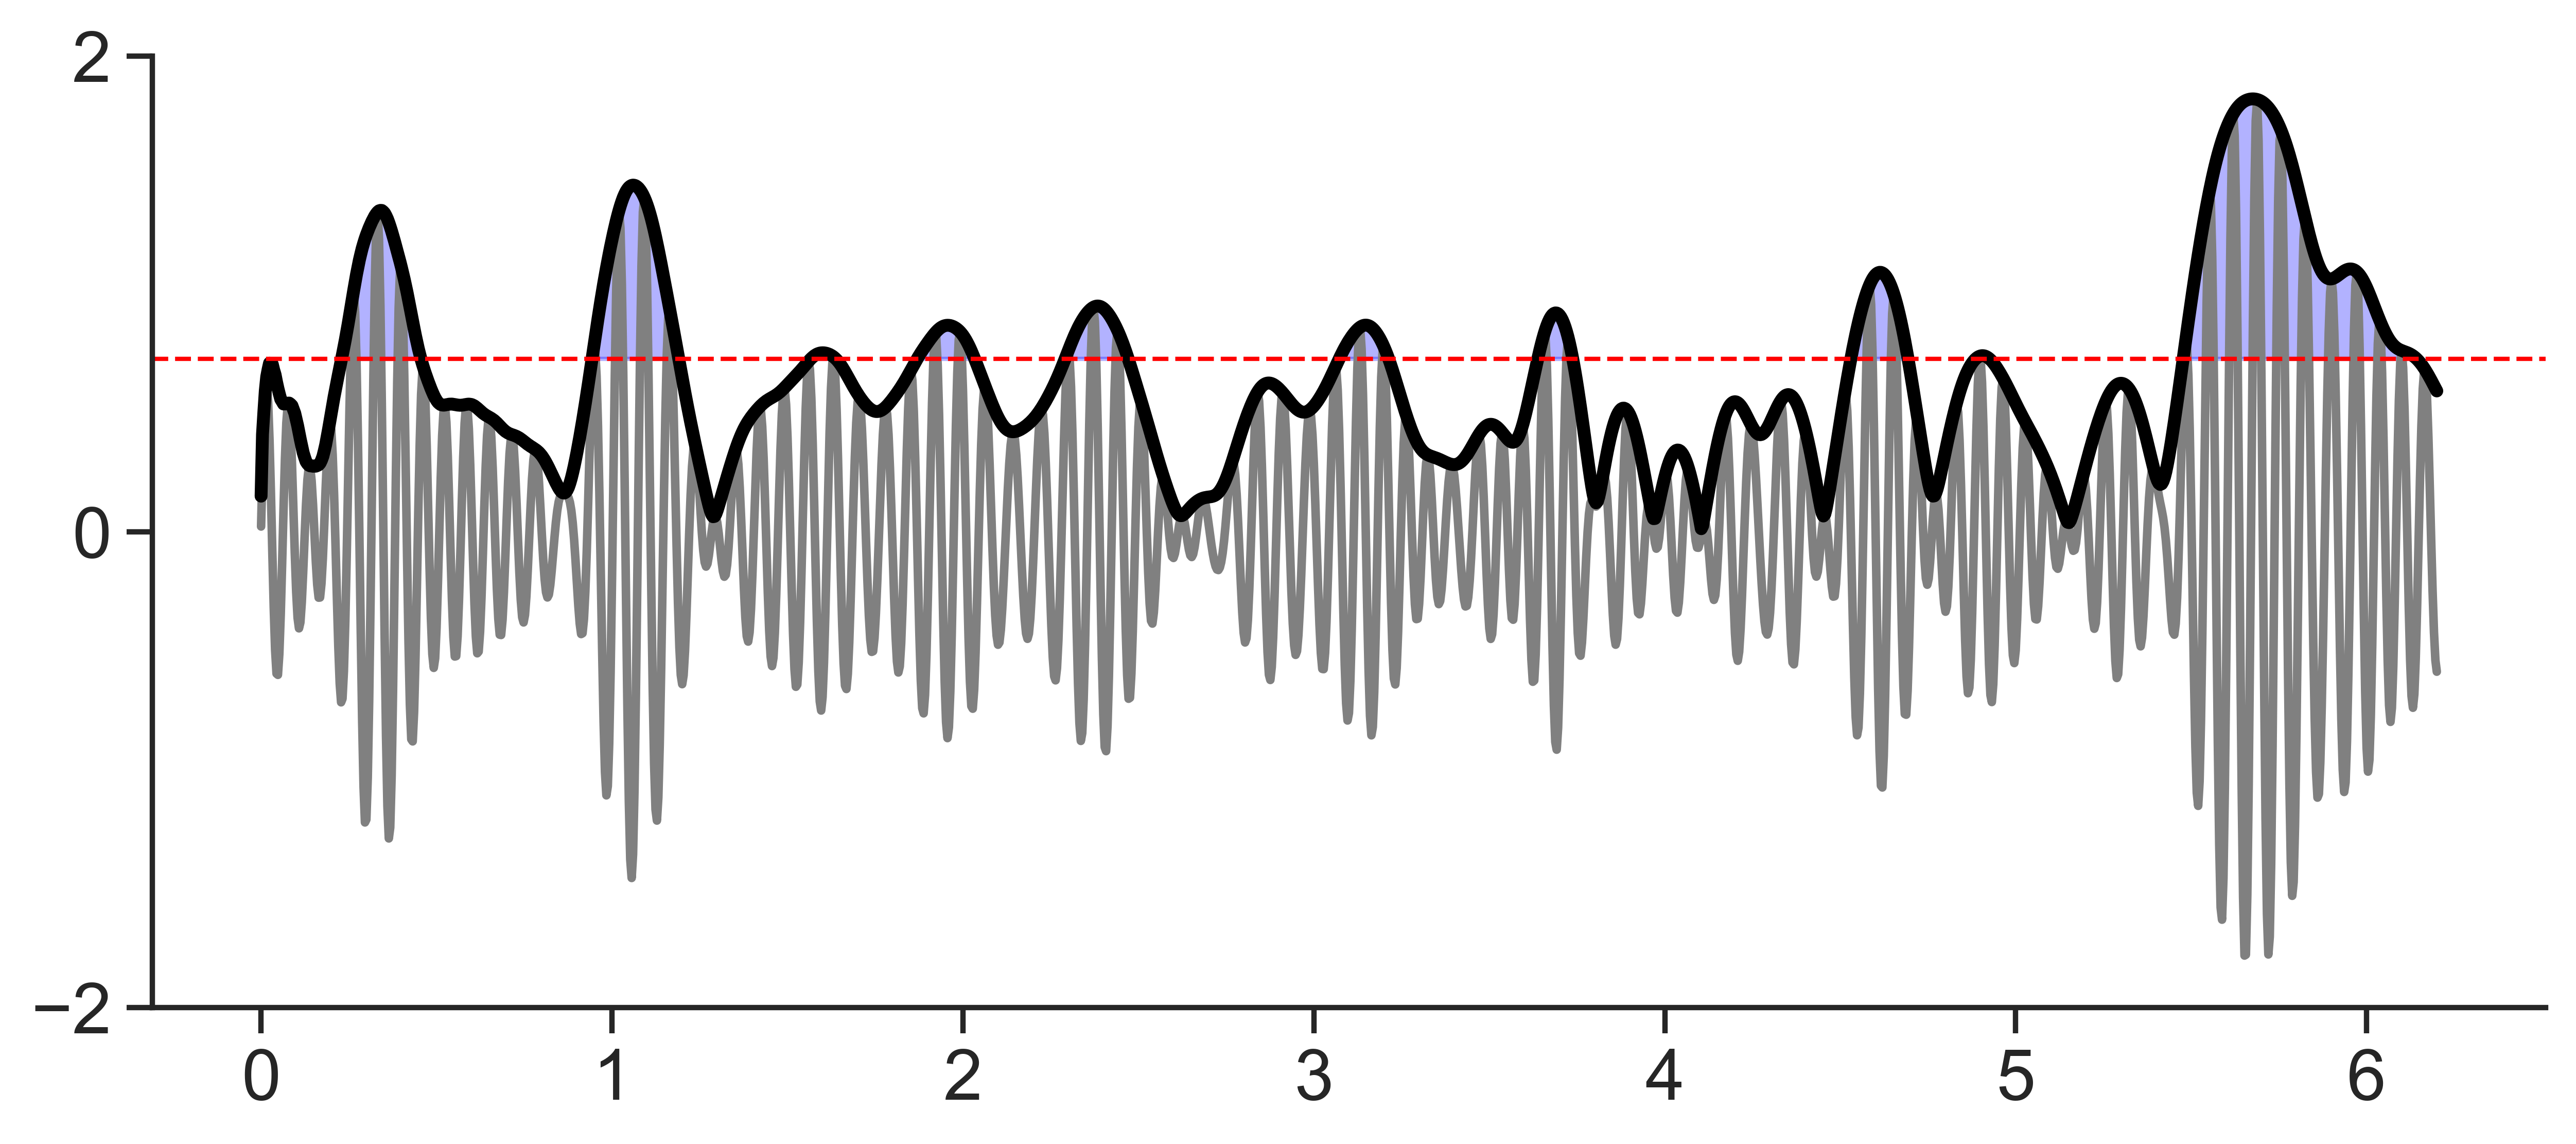

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
dbs036_filepath = os.path.join(resultsDir, 'DBS036_15s_BetaBand_Envelope.csv')
dbs036_df = pd.read_csv(dbs036_filepath)

# Filter the data to include only the first few seconds
filtered_df = dbs036_df[dbs036_df['Time (s)'] <= 6.2]

# Extract the threshold value
threshold = filtered_df['Threshold'].iloc[0]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
sns.set_style('ticks')

#set plot size
plt.figure(figsize=(10, 4))

# Create the plot
ax1 = sns.lineplot(x='Time (s)', y='Beta-Band Signal', data=filtered_df, color='grey')
ax2 = sns.lineplot(x='Time (s)', y='Hilbert Envelope', data=filtered_df, linestyle='-', color='black', linewidth = 3)

# Plot the horizontal threshold line
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1)

# Shade the area below Hilbert Envelope and above the threshold
time_values = filtered_df['Time (s)']
hilbert_envelope = filtered_df['Hilbert Envelope']

plt.fill_between(
    time_values,
    threshold,  # Start shading at the threshold
    hilbert_envelope,
    where=(hilbert_envelope > threshold),  # Shade only where Hilbert Envelope is above threshold
    interpolate=True,
    color='blue',
    alpha=0.3,
    label='Shaded Area'
)

# Customize the plot
plt.yticks(np.arange(-2, 3, 2))
plt.xticks(np.arange(0, 7, 1))
ax1.set(xlabel=None)
ax1.set(ylabel=None)
ax2.set(xlabel=None)
ax2.set(ylabel=None)

# Remove top and right spines
sns.despine()

# Show the plot
plt.show()




In [6]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

results_filepath = os.path.join(resultsDir, 'All_Patients_BetaBurst_Results.csv')
results = pd.read_csv(results_filepath)
status_df = results[results['IntervalType'] == 'status']
one_year_df = results[results['IntervalType'] == 'oneYear']

#print all the columns in status_df
print(one_year_df.columns)

# Merge the dataframes on 'Patient' and 'Channel' to align status and oneYear recordings
merged_df = pd.merge(
    status_df[['Patient', 'Channel', 'BurstDurationPercentage', 'BurstRate', 'AvgBurstAmplitude', 'AvgBurstDuration']],
    one_year_df[['Patient', 'Channel', 'BurstDurationPercentage', 'BurstRate', 'AvgBurstAmplitude', 'AvgBurstDuration']],
    on=['Patient', 'Channel'],
    suffixes=('_status', '_oneYear')
)

# Calculate means and standard deviations
burst_duration_mean_status = merged_df['BurstDurationPercentage_status'].mean()
burst_duration_std_status = merged_df['BurstDurationPercentage_status'].std()
burst_duration_mean_oneYear = merged_df['BurstDurationPercentage_oneYear'].mean()
burst_duration_std_oneYear = merged_df['BurstDurationPercentage_oneYear'].std()

burst_rate_mean_status = merged_df['BurstRate_status'].mean()
burst_rate_std_status = merged_df['BurstRate_status'].std()
burst_rate_mean_oneYear = merged_df['BurstRate_oneYear'].mean()
burst_rate_std_oneYear = merged_df['BurstRate_oneYear'].std()

burst_amplitude_mean_status = merged_df['AvgBurstAmplitude_status'].mean()
burst_amplitude_std_status = merged_df['AvgBurstAmplitude_status'].std()
burst_amplitude_mean_oneYear = merged_df['AvgBurstAmplitude_oneYear'].mean()
burst_amplitude_std_oneYear = merged_df['AvgBurstAmplitude_oneYear'].std()

avg_burst_duration_mean_status = merged_df['AvgBurstDuration_status'].mean()
avg_burst_duration_std_status = merged_df['AvgBurstDuration_status'].std()
avg_burst_duration_mean_oneYear = merged_df['AvgBurstDuration_oneYear'].mean()
avg_burst_duration_std_oneYear = merged_df['AvgBurstDuration_oneYear'].std()

# Paired t-test for means comparison
burst_duration_ttest = ttest_rel(
    merged_df['BurstDurationPercentage_status'], 
    merged_df['BurstDurationPercentage_oneYear']
)

burst_rate_ttest = ttest_rel(
    merged_df['BurstRate_status'], 
    merged_df['BurstRate_oneYear']
)

burst_amplitude_ttest = ttest_rel(
    merged_df['AvgBurstAmplitude_status'], 
    merged_df['AvgBurstAmplitude_oneYear']
)

avg_burst_duration_ttest = ttest_rel(
    merged_df['AvgBurstDuration_status'], 
    merged_df['AvgBurstDuration_oneYear']
)

# Wilcoxon signed-rank test (non-parametric alternative)
burst_duration_wilcoxon = wilcoxon(
    merged_df['BurstDurationPercentage_status'], 
    merged_df['BurstDurationPercentage_oneYear']
)

burst_rate_wilcoxon = wilcoxon(
    merged_df['BurstRate_status'], 
    merged_df['BurstRate_oneYear']
)

burst_amplitude_wilcoxon = wilcoxon(
    merged_df['AvgBurstAmplitude_status'], 
    merged_df['AvgBurstAmplitude_oneYear']
)

avg_burst_duration_wilcoxon = wilcoxon(
    merged_df['AvgBurstDuration_status'], 
    merged_df['AvgBurstDuration_oneYear']
)

# Display results
print("Burst Duration Percentage (Status vs. OneYear):")
print(f"Status - Mean: {burst_duration_mean_status:.3f}%, Std: {burst_duration_std_status:.3f}%")
print(f"OneYear - Mean: {burst_duration_mean_oneYear:.3f}%, Std: {burst_duration_std_oneYear:.3f}%")
print(f"Paired t-test: t-statistic = {burst_duration_ttest.statistic:.2f}, p-value = {burst_duration_ttest.pvalue:.4f}")
print(f"Wilcoxon test: W-statistic = {burst_duration_wilcoxon.statistic}, p-value = {burst_duration_wilcoxon.pvalue:.4f}\n")

print("Burst Rate (Status vs. OneYear):")
print(f"Status - Mean: {burst_rate_mean_status:.3f} bursts/min, Std: {burst_rate_std_status:.3f}")
print(f"OneYear - Mean: {burst_rate_mean_oneYear:.3f} bursts/min, Std: {burst_rate_std_oneYear:.3f}")
print(f"Paired t-test: t-statistic = {burst_rate_ttest.statistic:.2f}, p-value = {burst_rate_ttest.pvalue:.4f}")
print(f"Wilcoxon test: W-statistic = {burst_rate_wilcoxon.statistic}, p-value = {burst_rate_wilcoxon.pvalue:.4f}\n")

print("Burst Amplitude (Status vs. OneYear):")
print(f"Status - Mean: {burst_amplitude_mean_status:.3f}, Std: {burst_amplitude_std_status:.3f}")
print(f"OneYear - Mean: {burst_amplitude_mean_oneYear:.3f}, Std: {burst_amplitude_std_oneYear:.3f}")
print(f"Paired t-test: t-statistic = {burst_amplitude_ttest.statistic:.2f}, p-value = {burst_amplitude_ttest.pvalue:.4f}")
print(f"Wilcoxon test: W-statistic = {burst_amplitude_wilcoxon.statistic}, p-value = {burst_amplitude_wilcoxon.pvalue:.4f}\n")

print("Average Burst Duration (Status vs. OneYear):")
print(f"Status - Mean: {avg_burst_duration_mean_status:.3f} sec, Std: {avg_burst_duration_std_status:.3f} sec")
print(f"OneYear - Mean: {avg_burst_duration_mean_oneYear:.3f} sec, Std: {avg_burst_duration_std_oneYear:.3f} sec")
print(f"Paired t-test: t-statistic = {avg_burst_duration_ttest.statistic:.2f}, p-value = {avg_burst_duration_ttest.pvalue:.4f}")
print(f"Wilcoxon test: W-statistic = {avg_burst_duration_wilcoxon.statistic}, p-value = {avg_burst_duration_wilcoxon.pvalue:.4f}")



Index(['Patient', 'IntervalType', 'RecordingStartTime', 'Channel',
       'BetaPeakFrequency', 'BurstDurationPercentage', 'BurstRate',
       'AvgBurstAmplitude', 'AvgBurstDuration'],
      dtype='object')
Burst Duration Percentage (Status vs. OneYear):
Status - Mean: 22.615%, Std: 0.905%
OneYear - Mean: 22.544%, Std: 0.740%
Paired t-test: t-statistic = 1.91, p-value = 0.0559
Wilcoxon test: W-statistic = 197486.5, p-value = 0.0115

Burst Rate (Status vs. OneYear):
Status - Mean: 65.154 bursts/min, Std: 10.311
OneYear - Mean: 63.878 bursts/min, Std: 10.725
Paired t-test: t-statistic = 2.78, p-value = 0.0056
Wilcoxon test: W-statistic = 207129.0, p-value = 0.3305

Burst Amplitude (Status vs. OneYear):
Status - Mean: 0.901, Std: 0.316
OneYear - Mean: 0.616, Std: 0.251
Paired t-test: t-statistic = 22.96, p-value = 0.0000
Wilcoxon test: W-statistic = 56883.0, p-value = 0.0000

Average Burst Duration (Status vs. OneYear):
Status - Mean: 0.216 sec, Std: 0.050 sec
OneYear - Mean: 0.222 sec, St

In [18]:
#RECALCULATE INDIVIDUAL BURSTS FOR ASSESSING AMPLITUDE-DURATION RELATIONSHIP AND FOR PLOTS
from scipy.signal import butter, filtfilt, hilbert
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from scipy.stats import ttest_rel, wilcoxon

# Helper functions (as before)
def bandpass_filter(data, fs, lowcut, highcut):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data)

def compute_hilbert_envelope(data):
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

def extract_individual_bursts(beta_envelope, fs):
    threshold = np.percentile(beta_envelope, 75)
    bursts = beta_envelope > threshold

    burst_info = []  # List to store individual burst info
    current_burst = []

    for i, is_burst in enumerate(bursts):
        if is_burst:
            current_burst.append(i)
        elif current_burst:
            burst_duration = len(current_burst) / fs
            if burst_duration >= 0.1:  # Only include bursts >= 100 ms
                max_amplitude = max(beta_envelope[current_burst])
                burst_info.append({'MaxAmplitude': max_amplitude, 'Duration': burst_duration})
            current_burst = []

    return burst_info

# DataFrame to store all individual bursts
all_bursts_df = pd.DataFrame()

# Main loop for each patient and recording
for subjID in patList:
    # Load and combine time series data as before
    timeseries_df = pd.read_csv(os.path.join(lfpDir, f'{subjID}_timeseries.csv'), parse_dates=['DateTime (UTC)'], index_col='DateTime (UTC)')
    if subjID in ['DBS005', 'DBS013', 'DBS018', 'DBS021', 'DBS036']:
        file_path_NEW = os.path.join(lfpDir, f'{subjID}_timeseries_NEW1.csv')
        timeseries_NEW_df = pd.read_csv(file_path_NEW, parse_dates=['DateTime (UTC)'], index_col='DateTime (UTC)')
        timeseries_df = pd.concat([timeseries_df, timeseries_NEW_df], axis=0)
        timeseries_df = timeseries_df.loc[~timeseries_df.index.duplicated(keep='first')]

    implantDate = implantDates_df.loc[implantDates_df['Patient ID'] == subjID, 'Implant date'].values[0]
    implantDate = datetime.strptime(implantDate, '%Y-%m-%d')
    
    registry_df = clinVars_df.copy()
    registry_df = registry_df.loc[registry_df['Subject ID'] == subjID]
    if registry_df.empty:
        print('No registry data for patient', subjID)
        continue
    if pd.isna(registry_df['Date of Status dystonicus'].values[0]):
        print('No status dystonicus data for patient', subjID)
        continue
    
    status_date = datetime.strptime(registry_df['Date of Status dystonicus'].values[0], '%d-%b-%y')
    startDate = max(status_date, implantDate)
    one_year_after = startDate + timedelta(days=365)
    discharge_date = datetime.strptime(registry_df['Date of Discharge'].values[0], '%d-%b-%y')
    print('Processing patient', subjID, '.')

    # Extract extra status dystonicus dates
    extra_status_dates_str = extraSDDates_df.loc[extraSDDates_df['Subject ID'] == subjID, 'Date of Extra Status dystonicus'].values
    extra_status_dates = []
    if len(extra_status_dates_str) > 0 and not pd.isna(extra_status_dates_str[0]):
        extra_status_dates = [datetime.strptime(date.strip(), '%Y-%m-%d') for date in extra_status_dates_str[0].split(',')]

    # Filter recordings for status dystonicus (including extra dates)
    early_recordings = timeseries_df.loc[
        (timeseries_df.index >= startDate - timedelta(days=10)) &
        (timeseries_df.index <= startDate + timedelta(days=45))
    ]

    # Include recordings for each extra status date
    for extra_date in extra_status_dates:
        extra_recordings = timeseries_df.loc[
            (timeseries_df.index >= extra_date - timedelta(days=10)) &
            (timeseries_df.index <= extra_date + timedelta(days=45))
        ]
        early_recordings = pd.concat([early_recordings, extra_recordings])
        early_recordings = early_recordings.loc[~early_recordings.index.duplicated(keep='first')]

    # Filter recordings for one year later, explicitly excluding extra status dates
    excluded_dates = [(date - timedelta(days=10), date + timedelta(days=45)) for date in extra_status_dates]
    one_year_recordings = timeseries_df.loc[
        ((timeseries_df.index >= one_year_after - timedelta(days=270)) &
         (timeseries_df.index <= one_year_after + timedelta(days=10000))) |
        (timeseries_df.index < startDate - timedelta(days=15))
    ]

    # Exclude recordings that fall within any extra status dystonicus date range
    for start, end in excluded_dates:
        one_year_recordings = one_year_recordings.loc[
            (one_year_recordings.index < start) | (one_year_recordings.index > end)
        ]


    # For each segment, normalize, calculate PSD, find peak beta frequency, and analyze individual bursts
    for intervalType, recordings in [('status', early_recordings), ('oneYear', one_year_recordings)]:
        if not recordings.empty:
            contiguous_segments = []
            current_segment = []
            for time, data in recordings.iterrows():
                if not current_segment or (time - current_segment[-1] < timedelta(seconds=2)):
                    current_segment.append(time)
                else:
                    contiguous_segments.append(current_segment)
                    current_segment = [time]
            if current_segment:
                contiguous_segments.append(current_segment)

            for segment in contiguous_segments:
                segment_data = recordings.loc[segment[0]:segment[-1]]
                fs = 1 / (segment_data.index[1] - segment_data.index[0]).total_seconds()
                segment_duration = (segment[-1] - segment[0]).total_seconds()

                for channel in segment_data.columns[1:]:
                    optimal_hemisphere_channels = get_hemisphere_channels(subjID, channel) #Only take optimal channel and hemisphere data to use for bursting analysis
                    if channel.endswith('_RIGHT'):
                        hemisphere = 'RIGHT'
                        channel_clean = channel.replace('_RIGHT', '') #just channel, without hemisphere at end
                    elif channel.endswith('_LEFT'):
                        hemisphere = 'LEFT'
                        channel_clean = channel.replace('_LEFT', '') #just channel, without hemisphere at end
                    if channel_clean in optimal_hemisphere_channels and hemisphere == get_optimal_hemisphere(subjID): #If the channel is the optimal channel and optimal hemisphere, get data for bursting
                        channel_data = segment_data[channel].dropna().values
                        if len(channel_data) <= 2:
                            continue

                        # Z-score normalization
                        channel_data = (channel_data - np.mean(channel_data)) / np.std(channel_data)

                        # Calculate PSD
                        freqs, psd, _, _ = getWelch(channel_data, fs=fs)
                        psd /= np.sum(psd)

                        # Find peak frequency in beta-band
                        beta_indices = np.where((freqs >= 12.5) & (freqs <= 30))[0]
                        beta_peak_freq = freqs[beta_indices][np.argmax(psd[beta_indices])]

                        # Bandpass filter around beta peak frequency ±3 Hz
                        lowcut, highcut = beta_peak_freq - 3, beta_peak_freq + 3
                        beta_band_data = bandpass_filter(channel_data, fs, lowcut, highcut)

                        # Compute beta envelope
                        beta_envelope = compute_hilbert_envelope(beta_band_data)

                        # Extract individual bursts
                        bursts = extract_individual_bursts(beta_envelope, fs)

                        # Store burst information for each burst
                        burst_df = pd.DataFrame(bursts)
                        burst_df['Patient'] = subjID
                        burst_df['IntervalType'] = intervalType
                        burst_df['Channel'] = channel
                        burst_df['RecordingStartTime'] = segment[0]

                        # Concatenate to the global DataFrame
                        all_bursts_df = pd.concat([all_bursts_df, burst_df], ignore_index=True)

# Save all bursts to CSV
bursts_filepath = os.path.join(resultsDir, 'All_Individual_Bursts.csv')
all_bursts_df.to_csv(bursts_filepath, index=False)
print(f"All individual bursts saved to {bursts_filepath}")

# Statistical comparisons for 'status' vs. 'oneYear' for burst metrics
status_bursts = all_bursts_df[all_bursts_df['IntervalType'] == 'status']
one_year_bursts = all_bursts_df[all_bursts_df['IntervalType'] == 'oneYear']

# Merge the dataframes on 'Patient' and 'Channel' to align status and oneYear bursts
merged_bursts = pd.merge(
    status_bursts[['Patient', 'Channel', 'MaxAmplitude', 'Duration']],
    one_year_bursts[['Patient', 'Channel', 'MaxAmplitude', 'Duration']],
    on=['Patient', 'Channel'],
    suffixes=('_status', '_oneYear')
)


Processing patient DBS003 .
Processing patient DBS005 .
Processing patient DBS013 .
Processing patient DBS014 .
Processing patient DBS018 .
Processing patient DBS021 .
Processing patient DBS036 .
Processing patient DBS047 .
Processing patient DBS050 .
Processing patient DBS039 .
All individual bursts saved to /Users/arjunbalachandar/Desktop/University of Toronto/Research/Ibrahim Lab/Dystonia Project/Analysis/All_Individual_Bursts.csv
Max Amplitude (Status vs. OneYear):
Paired t-test: t-statistic = 2228.66, p-value = 0.0000
Wilcoxon test: W-statistic = 35498058683032.0, p-value = 0.0000

Burst Duration (Status vs. OneYear):
Paired t-test: t-statistic = 125.52, p-value = 0.0000
Wilcoxon test: W-statistic = 76174432915120.0, p-value = 0.0000


In [8]:
import pandas as pd

# Separate the bursts into 'status' and 'oneYear'
status_bursts = all_bursts_df[all_bursts_df['IntervalType'] == 'status']
one_year_bursts = all_bursts_df[all_bursts_df['IntervalType'] == 'oneYear']

# Calculate mean and standard deviation for burst amplitude and duration for 'status'
status_amplitude_mean = status_bursts['MaxAmplitude'].mean()
status_amplitude_std = status_bursts['MaxAmplitude'].std()
status_duration_mean = status_bursts['Duration'].mean()
status_duration_std = status_bursts['Duration'].std()

# Calculate mean and standard deviation for burst amplitude and duration for 'oneYear'
one_year_amplitude_mean = one_year_bursts['MaxAmplitude'].mean()
one_year_amplitude_std = one_year_bursts['MaxAmplitude'].std()
one_year_duration_mean = one_year_bursts['Duration'].mean()
one_year_duration_std = one_year_bursts['Duration'].std()

# Display results
print("Burst Metrics for 'status':")
print(f"Max Amplitude - Mean: {status_amplitude_mean:.2f}, Std: {status_amplitude_std:.2f}")
print(f"Burst Duration - Mean: {status_duration_mean:.2f} sec, Std: {status_duration_std:.2f} sec\n")

print("Burst Metrics for 'oneYear':")
print(f"Max Amplitude - Mean: {one_year_amplitude_mean:.2f}, Std: {one_year_amplitude_std:.2f}")
print(f"Burst Duration - Mean: {one_year_duration_mean:.2f} sec, Std: {one_year_duration_std:.2f} sec")


NameError: name 'all_bursts_df' is not defined

In [9]:
#REPEAT INITIAL STATS SHOWN
import pandas as pd
from scipy.stats import ttest_rel, mannwhitneyu

# Assuming 'results' DataFrame is already created and contains the results from the previous step
# Filter for 'status' and 'oneYear' intervals only
results_filepath = os.path.join(resultsDir, 'All_Patients_BetaBurst_Results.csv')
results = pd.read_csv(results_filepath)
status_df = results[results['IntervalType'] == 'status']
one_year_df = results[results['IntervalType'] == 'oneYear']

# Print all the columns in one_year_df
print(one_year_df.columns)

# Merge the dataframes on 'Patient' and 'Channel' to align status and oneYear recordings
merged_df = pd.merge(
    status_df[['Patient', 'Channel', 'BurstDurationPercentage', 'BurstRate', 'AvgBurstAmplitude', 'AvgBurstDuration']],
    one_year_df[['Patient', 'Channel', 'BurstDurationPercentage', 'BurstRate', 'AvgBurstAmplitude', 'AvgBurstDuration']],
    on=['Patient', 'Channel'],
    suffixes=('_status', '_oneYear')
)

# Calculate means and standard deviations
burst_duration_mean_status = merged_df['BurstDurationPercentage_status'].mean()
burst_duration_std_status = merged_df['BurstDurationPercentage_status'].std()
burst_duration_mean_oneYear = merged_df['BurstDurationPercentage_oneYear'].mean()
burst_duration_std_oneYear = merged_df['BurstDurationPercentage_oneYear'].std()

burst_rate_mean_status = merged_df['BurstRate_status'].mean()
burst_rate_std_status = merged_df['BurstRate_status'].std()
burst_rate_mean_oneYear = merged_df['BurstRate_oneYear'].mean()
burst_rate_std_oneYear = merged_df['BurstRate_oneYear'].std()

burst_amplitude_mean_status = merged_df['AvgBurstAmplitude_status'].mean()
burst_amplitude_std_status = merged_df['AvgBurstAmplitude_status'].std()
burst_amplitude_mean_oneYear = merged_df['AvgBurstAmplitude_oneYear'].mean()
burst_amplitude_std_oneYear = merged_df['AvgBurstAmplitude_oneYear'].std()

avg_burst_duration_mean_status = merged_df['AvgBurstDuration_status'].mean()
avg_burst_duration_std_status = merged_df['AvgBurstDuration_status'].std()
avg_burst_duration_mean_oneYear = merged_df['AvgBurstDuration_oneYear'].mean()
avg_burst_duration_std_oneYear = merged_df['AvgBurstDuration_oneYear'].std()

# Paired t-test for means comparison
burst_duration_ttest = ttest_rel(
    merged_df['BurstDurationPercentage_status'], 
    merged_df['BurstDurationPercentage_oneYear']
)

burst_rate_ttest = ttest_rel(
    merged_df['BurstRate_status'], 
    merged_df['BurstRate_oneYear']
)

burst_amplitude_ttest = ttest_rel(
    merged_df['AvgBurstAmplitude_status'], 
    merged_df['AvgBurstAmplitude_oneYear']
)

avg_burst_duration_ttest = ttest_rel(
    merged_df['AvgBurstDuration_status'], 
    merged_df['AvgBurstDuration_oneYear']
)

# Mann-Whitney U test (non-parametric alternative for independent samples)
burst_duration_mwu = mannwhitneyu(
    merged_df['BurstDurationPercentage_status'], 
    merged_df['BurstDurationPercentage_oneYear'],
    alternative='two-sided'
)

burst_rate_mwu = mannwhitneyu(
    merged_df['BurstRate_status'], 
    merged_df['BurstRate_oneYear'],
    alternative='two-sided'
)

burst_amplitude_mwu = mannwhitneyu(
    merged_df['AvgBurstAmplitude_status'], 
    merged_df['AvgBurstAmplitude_oneYear'],
    alternative='two-sided'
)

avg_burst_duration_mwu = mannwhitneyu(
    merged_df['AvgBurstDuration_status'], 
    merged_df['AvgBurstDuration_oneYear'],
    alternative='two-sided'
)

# Display results
print("Burst Duration Percentage (Status vs. OneYear):")
print(f"Status - Mean: {burst_duration_mean_status:.3f}%, Std: {burst_duration_std_status:.3f}%")
print(f"OneYear - Mean: {burst_duration_mean_oneYear:.3f}%, Std: {burst_duration_std_oneYear:.3f}%")
#print(f"Paired t-test: t-statistic = {burst_duration_ttest.statistic:.2f}, p-value = {burst_duration_ttest.pvalue:.4f}")
print(f"Mann-Whitney U test: U-statistic = {burst_duration_mwu.statistic:.2f}, p-value = {burst_duration_mwu.pvalue:.4f}\n")

print("Burst Rate (Status vs. OneYear):")
print(f"Status - Mean: {burst_rate_mean_status:.3f} bursts/min, Std: {burst_rate_std_status:.3f}")
print(f"OneYear - Mean: {burst_rate_mean_oneYear:.3f} bursts/min, Std: {burst_rate_std_oneYear:.3f}")
#print(f"Paired t-test: t-statistic = {burst_rate_ttest.statistic:.2f}, p-value = {burst_rate_ttest.pvalue:.4f}")
print(f"Mann-Whitney U test: U-statistic = {burst_rate_mwu.statistic:.2f}, p-value = {burst_rate_mwu.pvalue:.4f}\n")

print("Burst Amplitude (Status vs. OneYear):")
print(f"Status - Mean: {burst_amplitude_mean_status:.3f}, Std: {burst_amplitude_std_status:.3f}")
print(f"OneYear - Mean: {burst_amplitude_mean_oneYear:.3f}, Std: {burst_amplitude_std_oneYear:.3f}")
#print(f"Paired t-test: t-statistic = {burst_amplitude_ttest.statistic:.2f}, p-value = {burst_amplitude_ttest.pvalue:.4f}")
print(f"Mann-Whitney U test: U-statistic = {burst_amplitude_mwu.statistic:.2f}, p-value = {burst_amplitude_mwu.pvalue:.4f}\n")

print("Average Burst Duration (Status vs. OneYear):")
print(f"Status - Mean: {avg_burst_duration_mean_status:.3f} sec, Std: {avg_burst_duration_std_status:.3f} sec")
print(f"OneYear - Mean: {avg_burst_duration_mean_oneYear:.3f} sec, Std: {avg_burst_duration_std_oneYear:.3f} sec")
#print(f"Paired t-test: t-statistic = {avg_burst_duration_ttest.statistic:.2f}, p-value = {avg_burst_duration_ttest.pvalue:.4f}")
print(f"Mann-Whitney U test: U-statistic = {avg_burst_duration_mwu.statistic:.2f}, p-value = {avg_burst_duration_mwu.pvalue:.4f}")


Index(['Patient', 'IntervalType', 'RecordingStartTime', 'Channel',
       'BetaPeakFrequency', 'BurstDurationPercentage', 'BurstRate',
       'AvgBurstAmplitude', 'AvgBurstDuration'],
      dtype='object')
Burst Duration Percentage (Status vs. OneYear):
Status - Mean: 22.615%, Std: 0.905%
OneYear - Mean: 22.544%, Std: 0.740%
Mann-Whitney U test: U-statistic = 463892.00, p-value = 0.0174

Burst Rate (Status vs. OneYear):
Status - Mean: 65.154 bursts/min, Std: 10.311
OneYear - Mean: 63.878 bursts/min, Std: 10.725
Mann-Whitney U test: U-statistic = 439655.00, p-value = 0.7655

Burst Amplitude (Status vs. OneYear):
Status - Mean: 0.901, Std: 0.316
OneYear - Mean: 0.616, Std: 0.251
Mann-Whitney U test: U-statistic = 649412.00, p-value = 0.0000

Average Burst Duration (Status vs. OneYear):
Status - Mean: 0.216 sec, Std: 0.050 sec
OneYear - Mean: 0.222 sec, Std: 0.065 sec
Mann-Whitney U test: U-statistic = 438744.00, p-value = 0.8258


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_50167/951564535.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




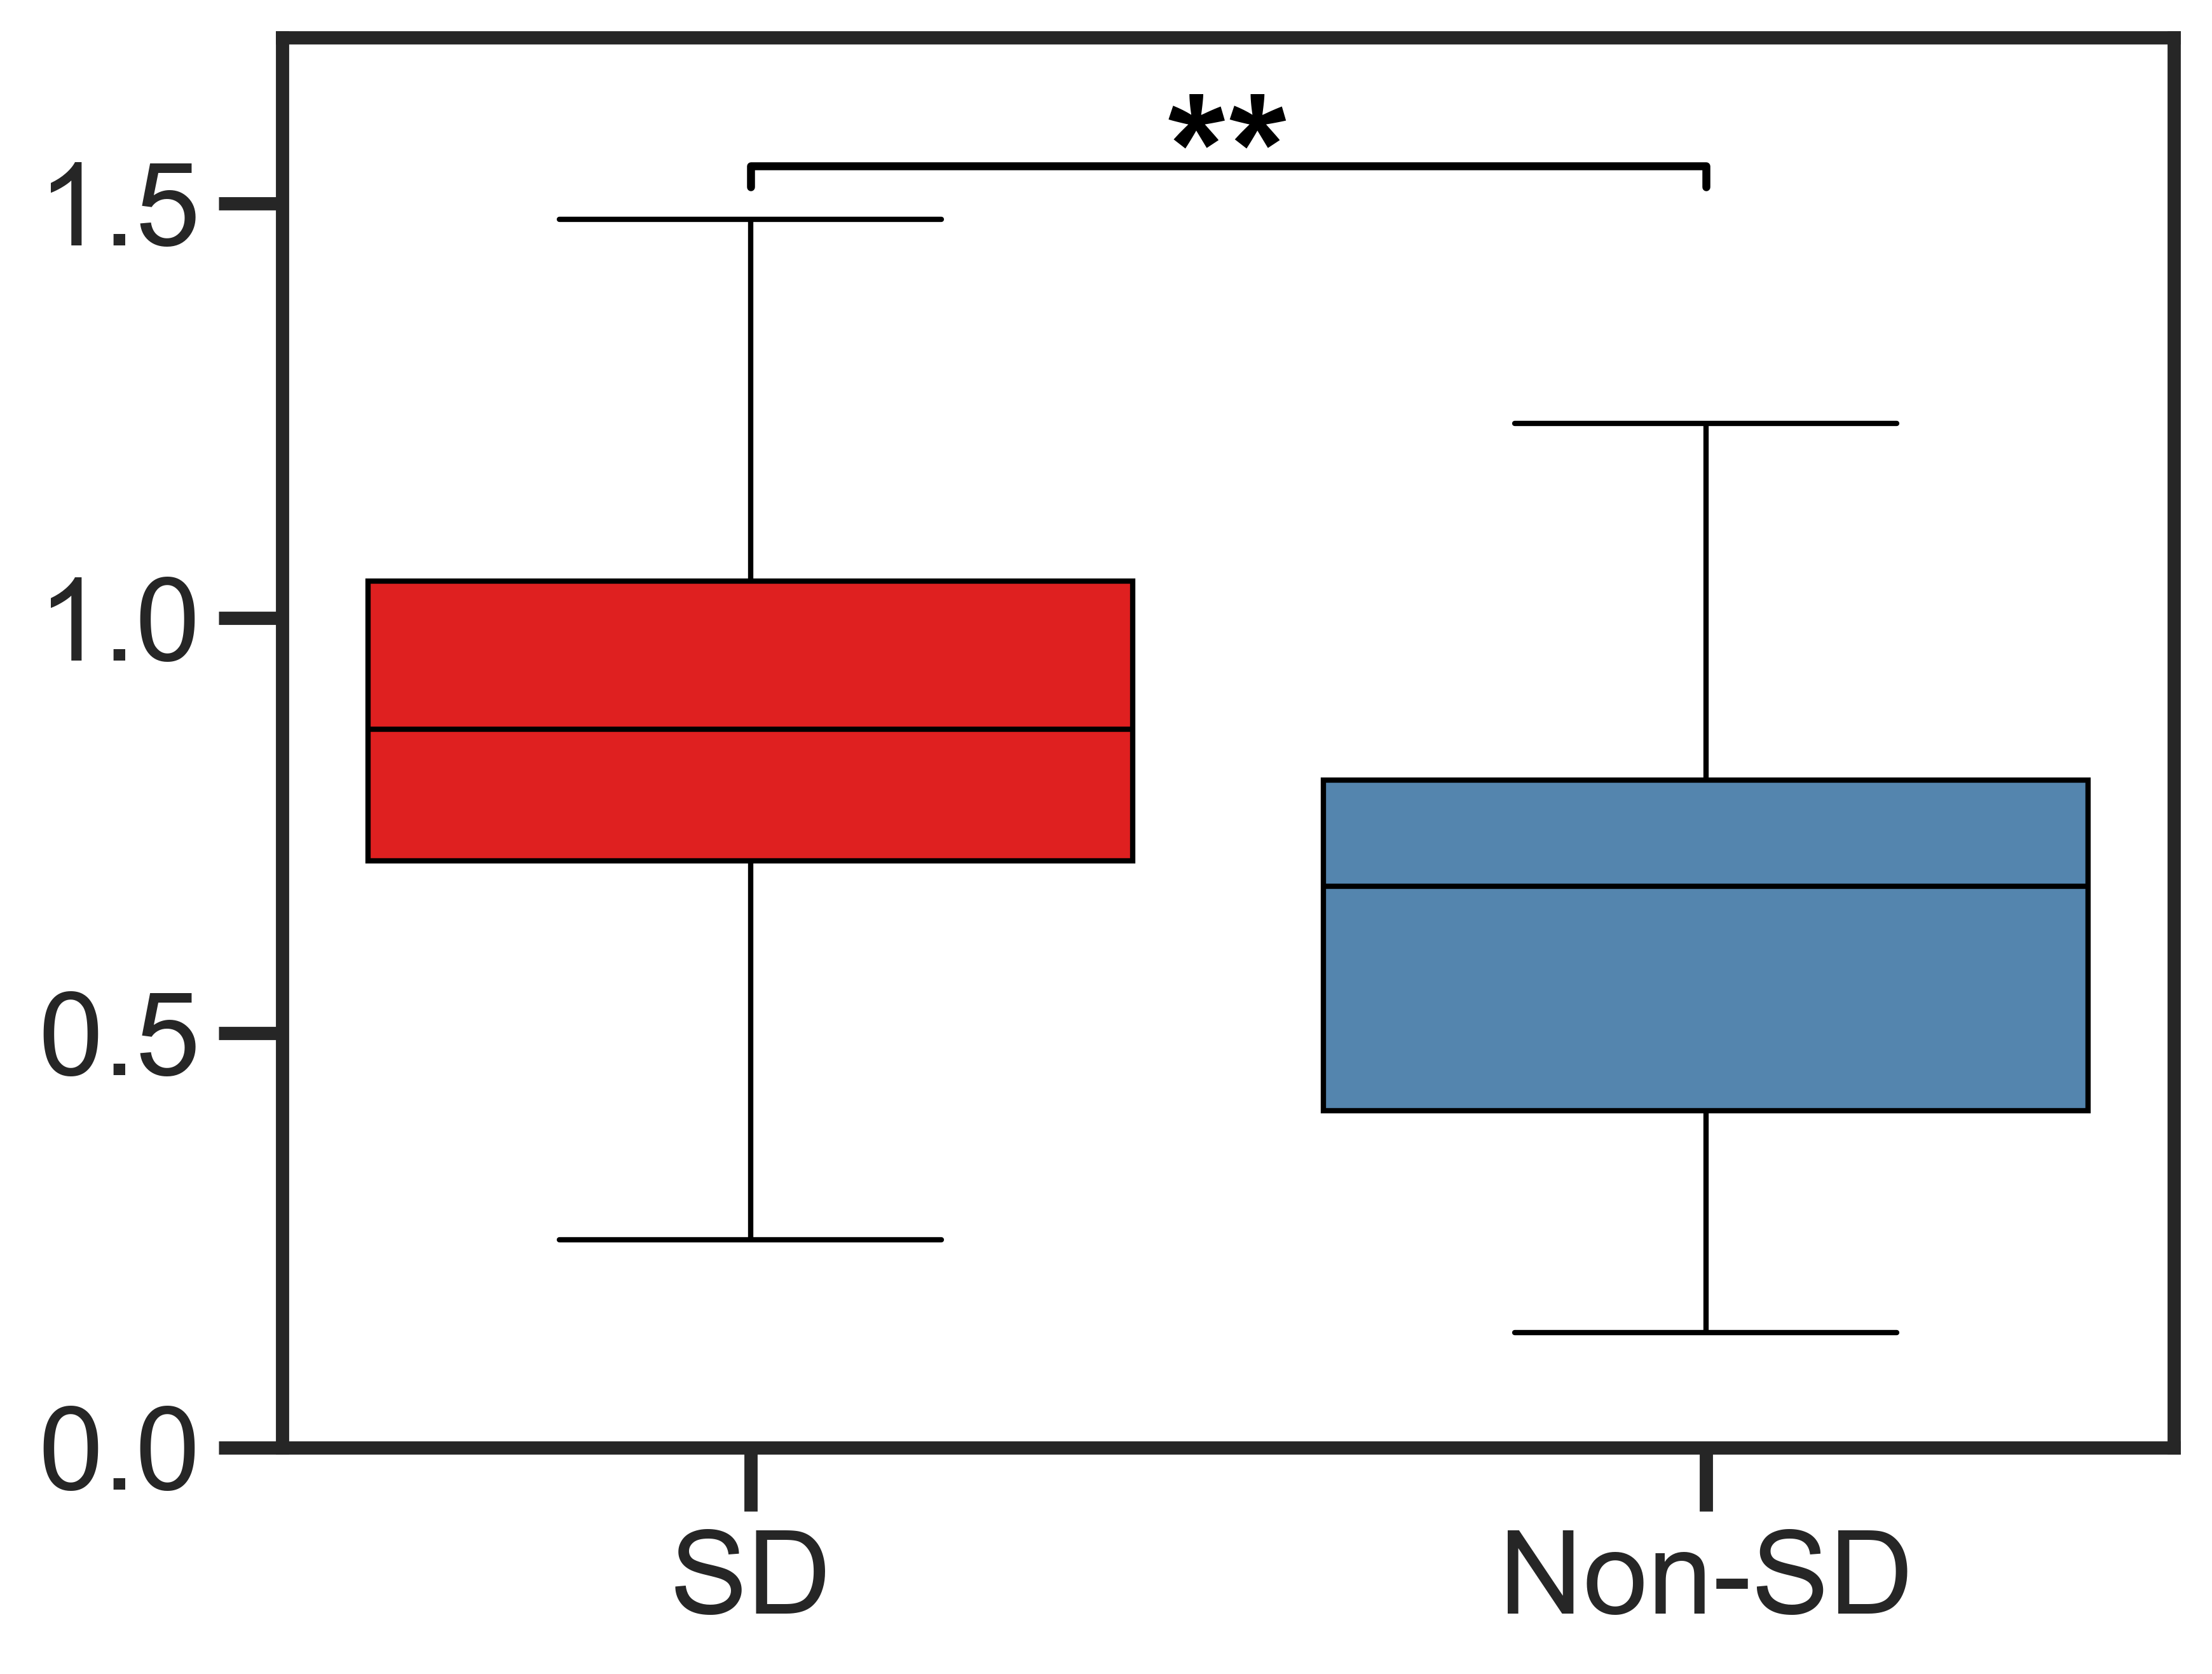

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_50167/951564535.py:59: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




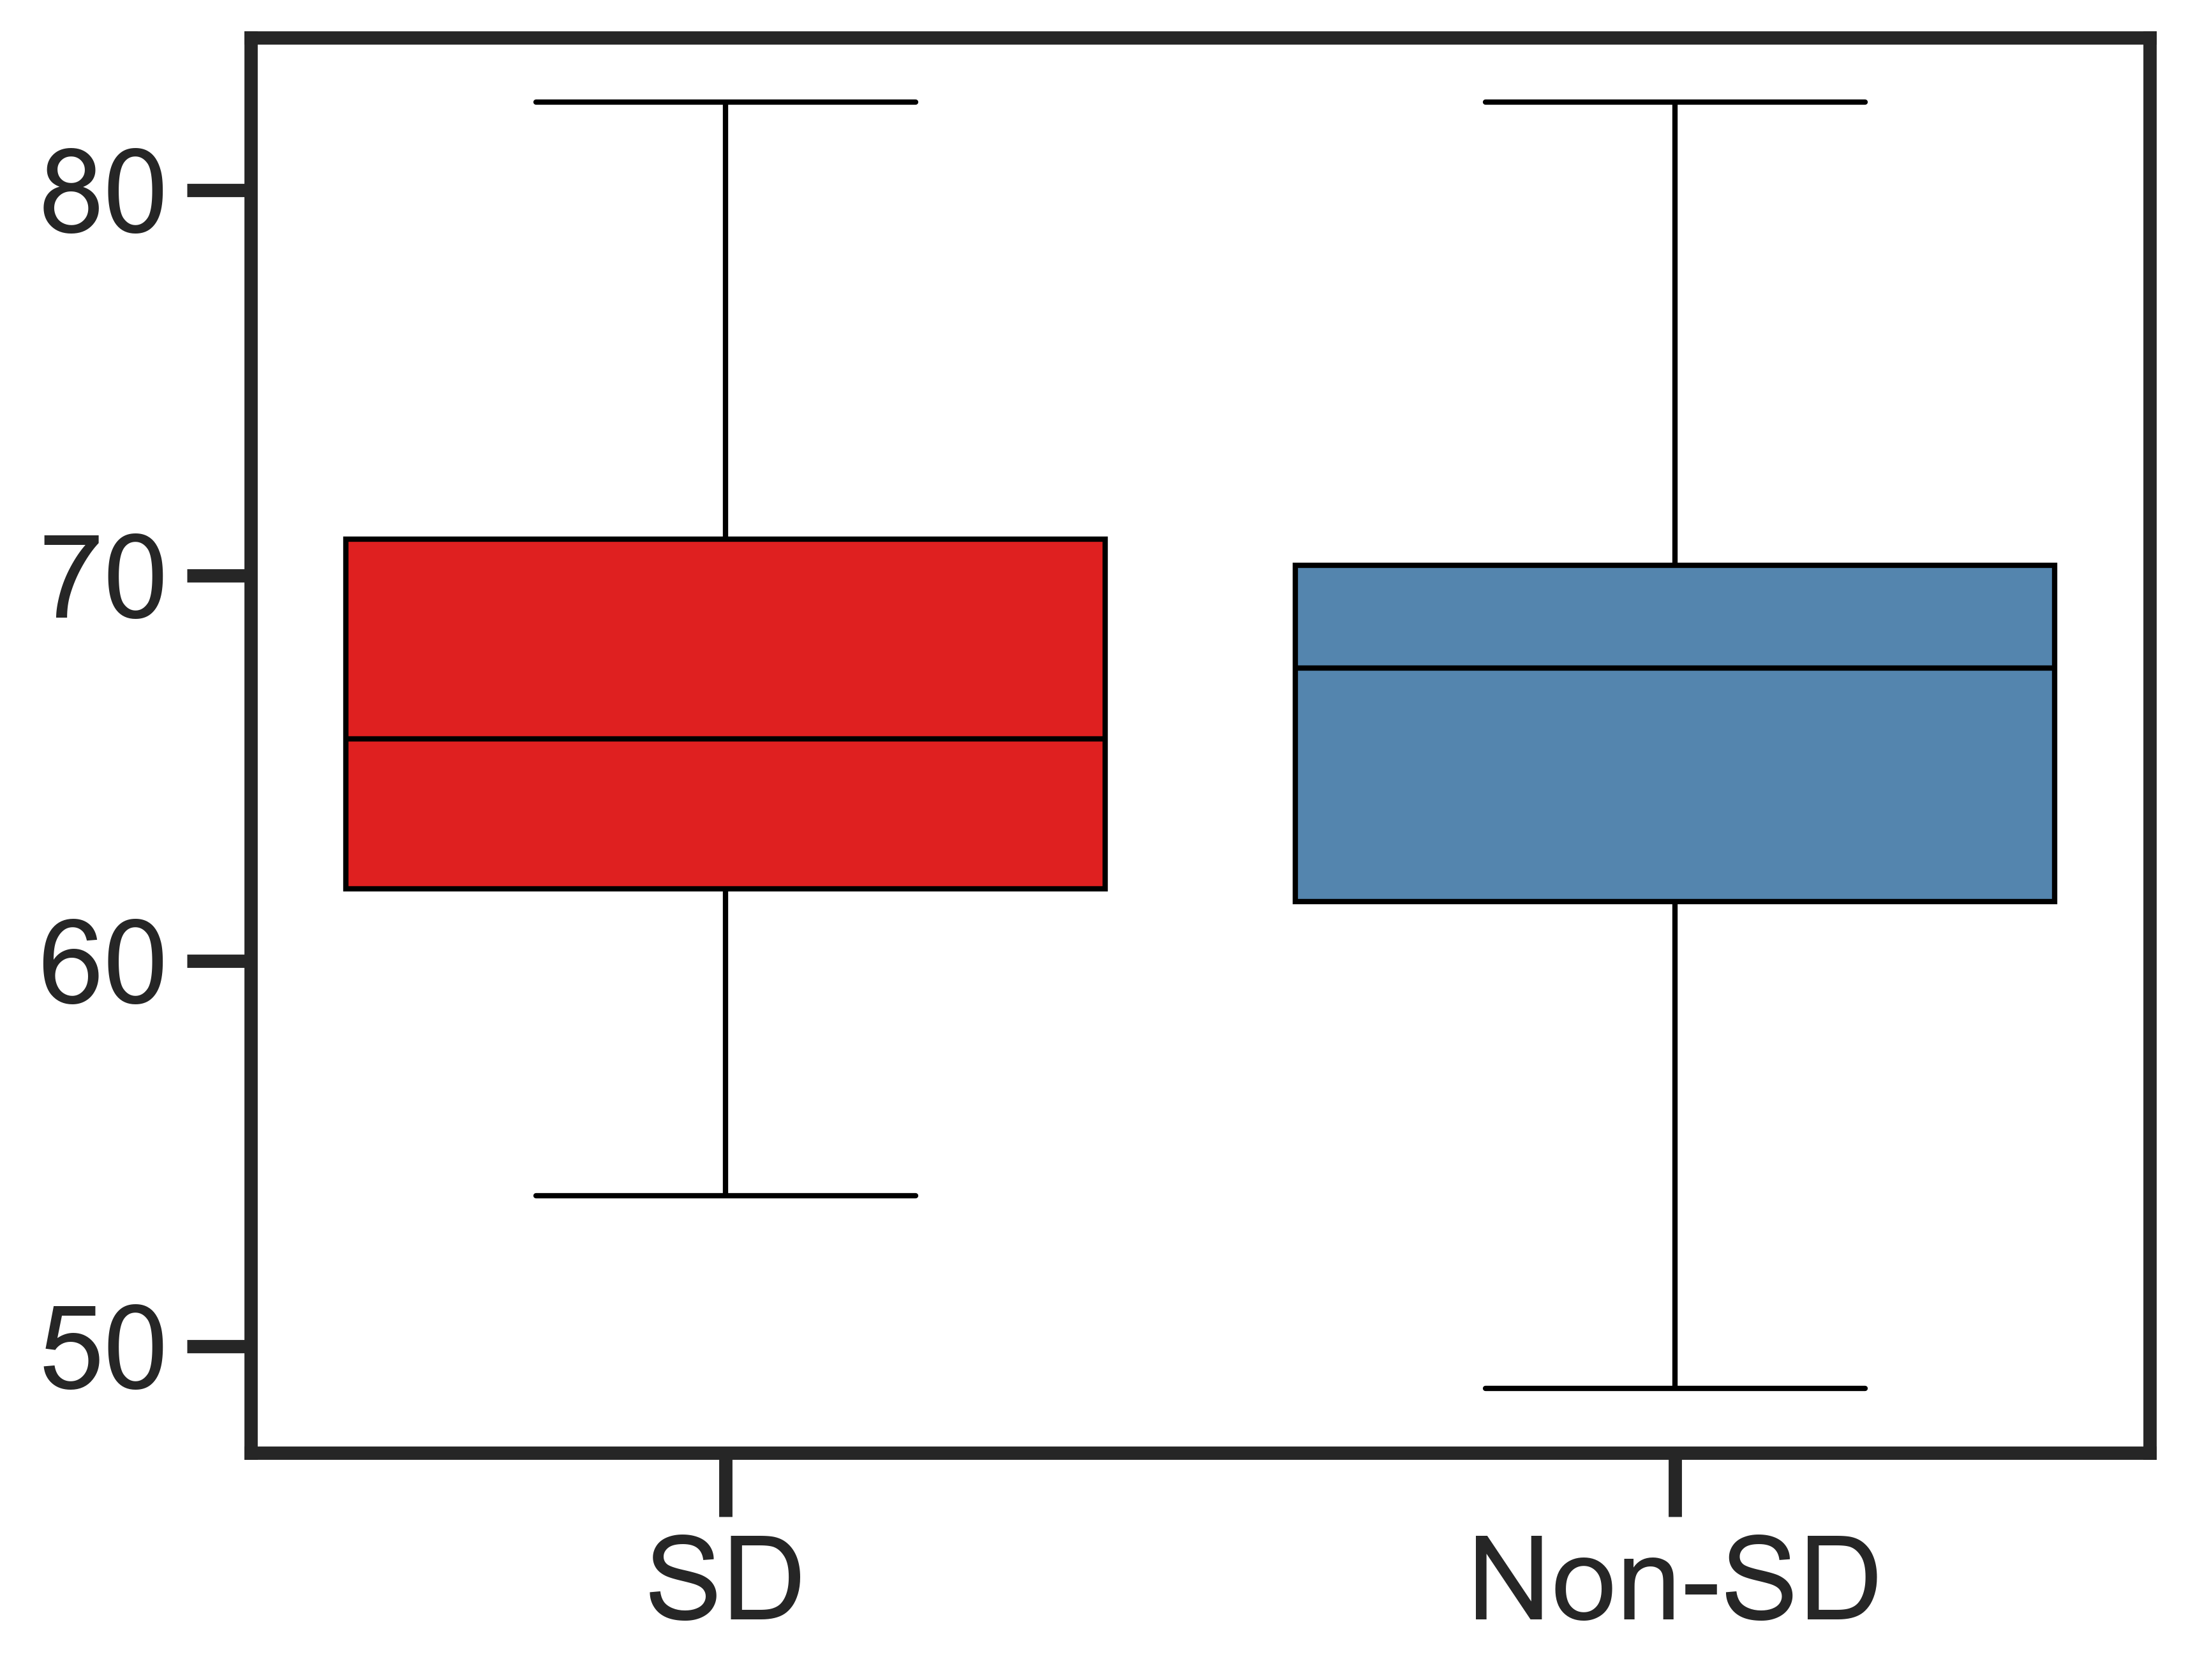

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_50167/951564535.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_50167/951564535.py:92: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




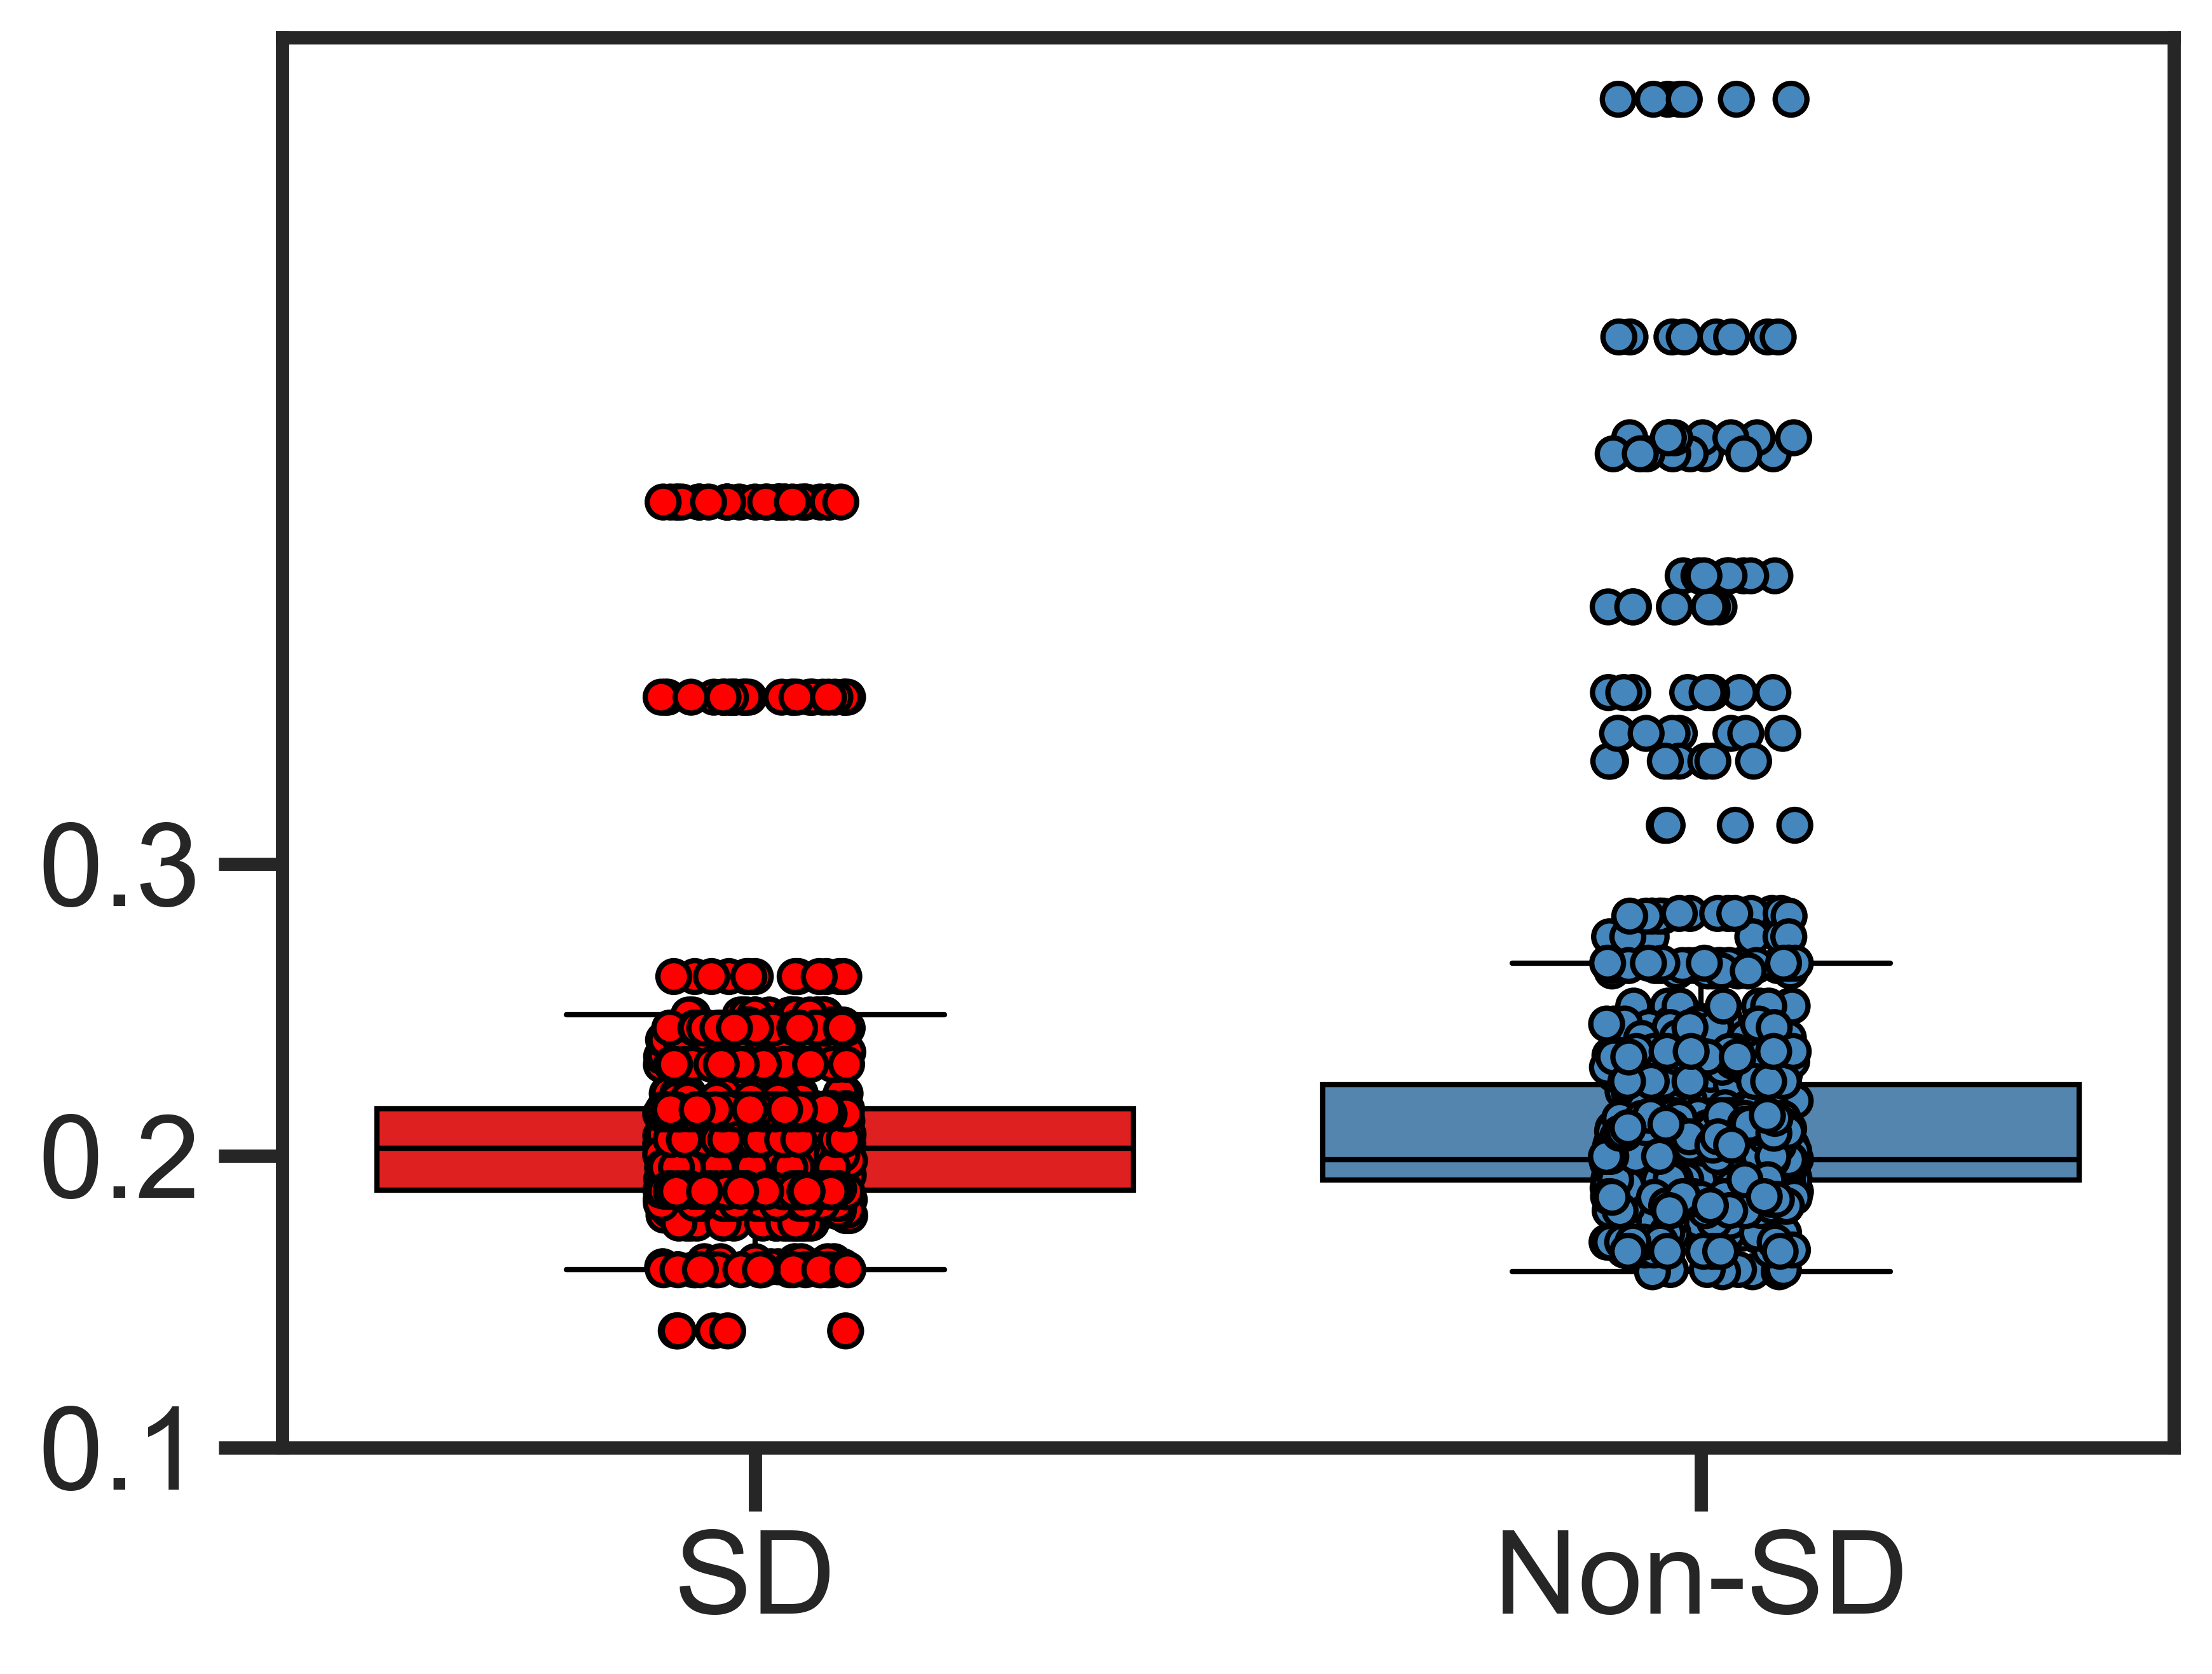

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Filter for 'status' and 'oneYear' intervals
status_df = results[results['IntervalType'] == 'status']
one_year_df = results[results['IntervalType'] == 'oneYear']

# Merge the dataframes on 'Patient' and 'Channel'
merged_df = pd.merge(
    status_df[['Patient', 'Channel', 'BurstRate', 'AvgBurstAmplitude', 'AvgBurstDuration']],
    one_year_df[['Patient', 'Channel', 'BurstRate', 'AvgBurstAmplitude', 'AvgBurstDuration']],
    on=['Patient', 'Channel'],
    suffixes=('_status', '_oneYear')
)

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Burst Rate': pd.concat([merged_df['BurstRate_status'], merged_df['BurstRate_oneYear']]),
    'Condition': ['SD'] * len(merged_df) + ['Non-SD'] * len(merged_df),
    'Burst Amplitude': pd.concat([merged_df['AvgBurstAmplitude_status'], merged_df['AvgBurstAmplitude_oneYear']]),
    'Average Burst Duration': pd.concat([merged_df['AvgBurstDuration_status'], merged_df['AvgBurstDuration_oneYear']])
})

# Initialize Seaborn style
sns.set_style("ticks")
sns.set_context("poster")

# Plot Burst Amplitude
ax1 = sns.boxplot(
    x='Condition',
    y='Burst Amplitude',
    data=plot_data,
    palette=['red', '#4587BD'],
    showfliers=False,  # Suppress outlier points
    boxprops=dict(edgecolor='black'),  # Black outline for boxes
    whiskerprops=dict(color='black'),  # Black whiskers
    capprops=dict(color='black'),  # Black caps on whiskers
    medianprops=dict(color='black')  # Black median line
)
burst_amplitude_mwu = mannwhitneyu(merged_df['AvgBurstAmplitude_status'], merged_df['AvgBurstAmplitude_oneYear'], alternative='two-sided')
ax1.set(xlabel=None)
ax1.set(ylabel=None)
x1, x2 = 0, 1  # Positions of the two groups
y, h, col = plot_data['Burst Amplitude'].max() - 0.2, 0.025, 'black'  # Adjust height (h is smaller)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h-0.09, "**", ha='center', va='bottom', color=col, fontsize=30, weight='bold')  # Bold text
plt.ylim(0,1.7)
plt.show()

# Plot Burst Rate
ax2 = sns.boxplot(
    x='Condition',
    y='Burst Rate',
    data=plot_data,
    palette=['red', '#4587BD'],
    showfliers=False,  # Suppress outlier points
    boxprops=dict(edgecolor='black'),  # Black outline for boxes
    whiskerprops=dict(color='black'),  # Black whiskers
    capprops=dict(color='black'),  # Black caps on whiskers
    medianprops=dict(color='black')  # Black median line
)

burst_rate_mwu = mannwhitneyu(merged_df['BurstRate_status'], merged_df['BurstRate_oneYear'], alternative='two-sided')
#axes[1].set_title(f'p = {burst_rate_mwu.pvalue:.4f}')
#axes[1].set_ylabel('Mean Burst Rate [bursts/s]')
ax2.set(xlabel=None)
ax2.set(ylabel=None)
plt.show()

# Plot Average Burst Duration
ax3 = sns.boxplot(
    x='Condition',
    y='Average Burst Duration',
    data=plot_data,
    palette=['red', '#4587BD'],
    showfliers=False,  # Suppress outlier points
    boxprops=dict(edgecolor='black'),  # Black outline for boxes
    whiskerprops=dict(color='black'),  # Black whiskers
    capprops=dict(color='black'),  # Black caps on whiskers
    medianprops=dict(color='black')  # Black median line
)

ax3.set(xlabel=None)
ax3.set(ylabel=None)
plt.yticks(np.arange(0.1, 0.31, 0.1))
plt.show()

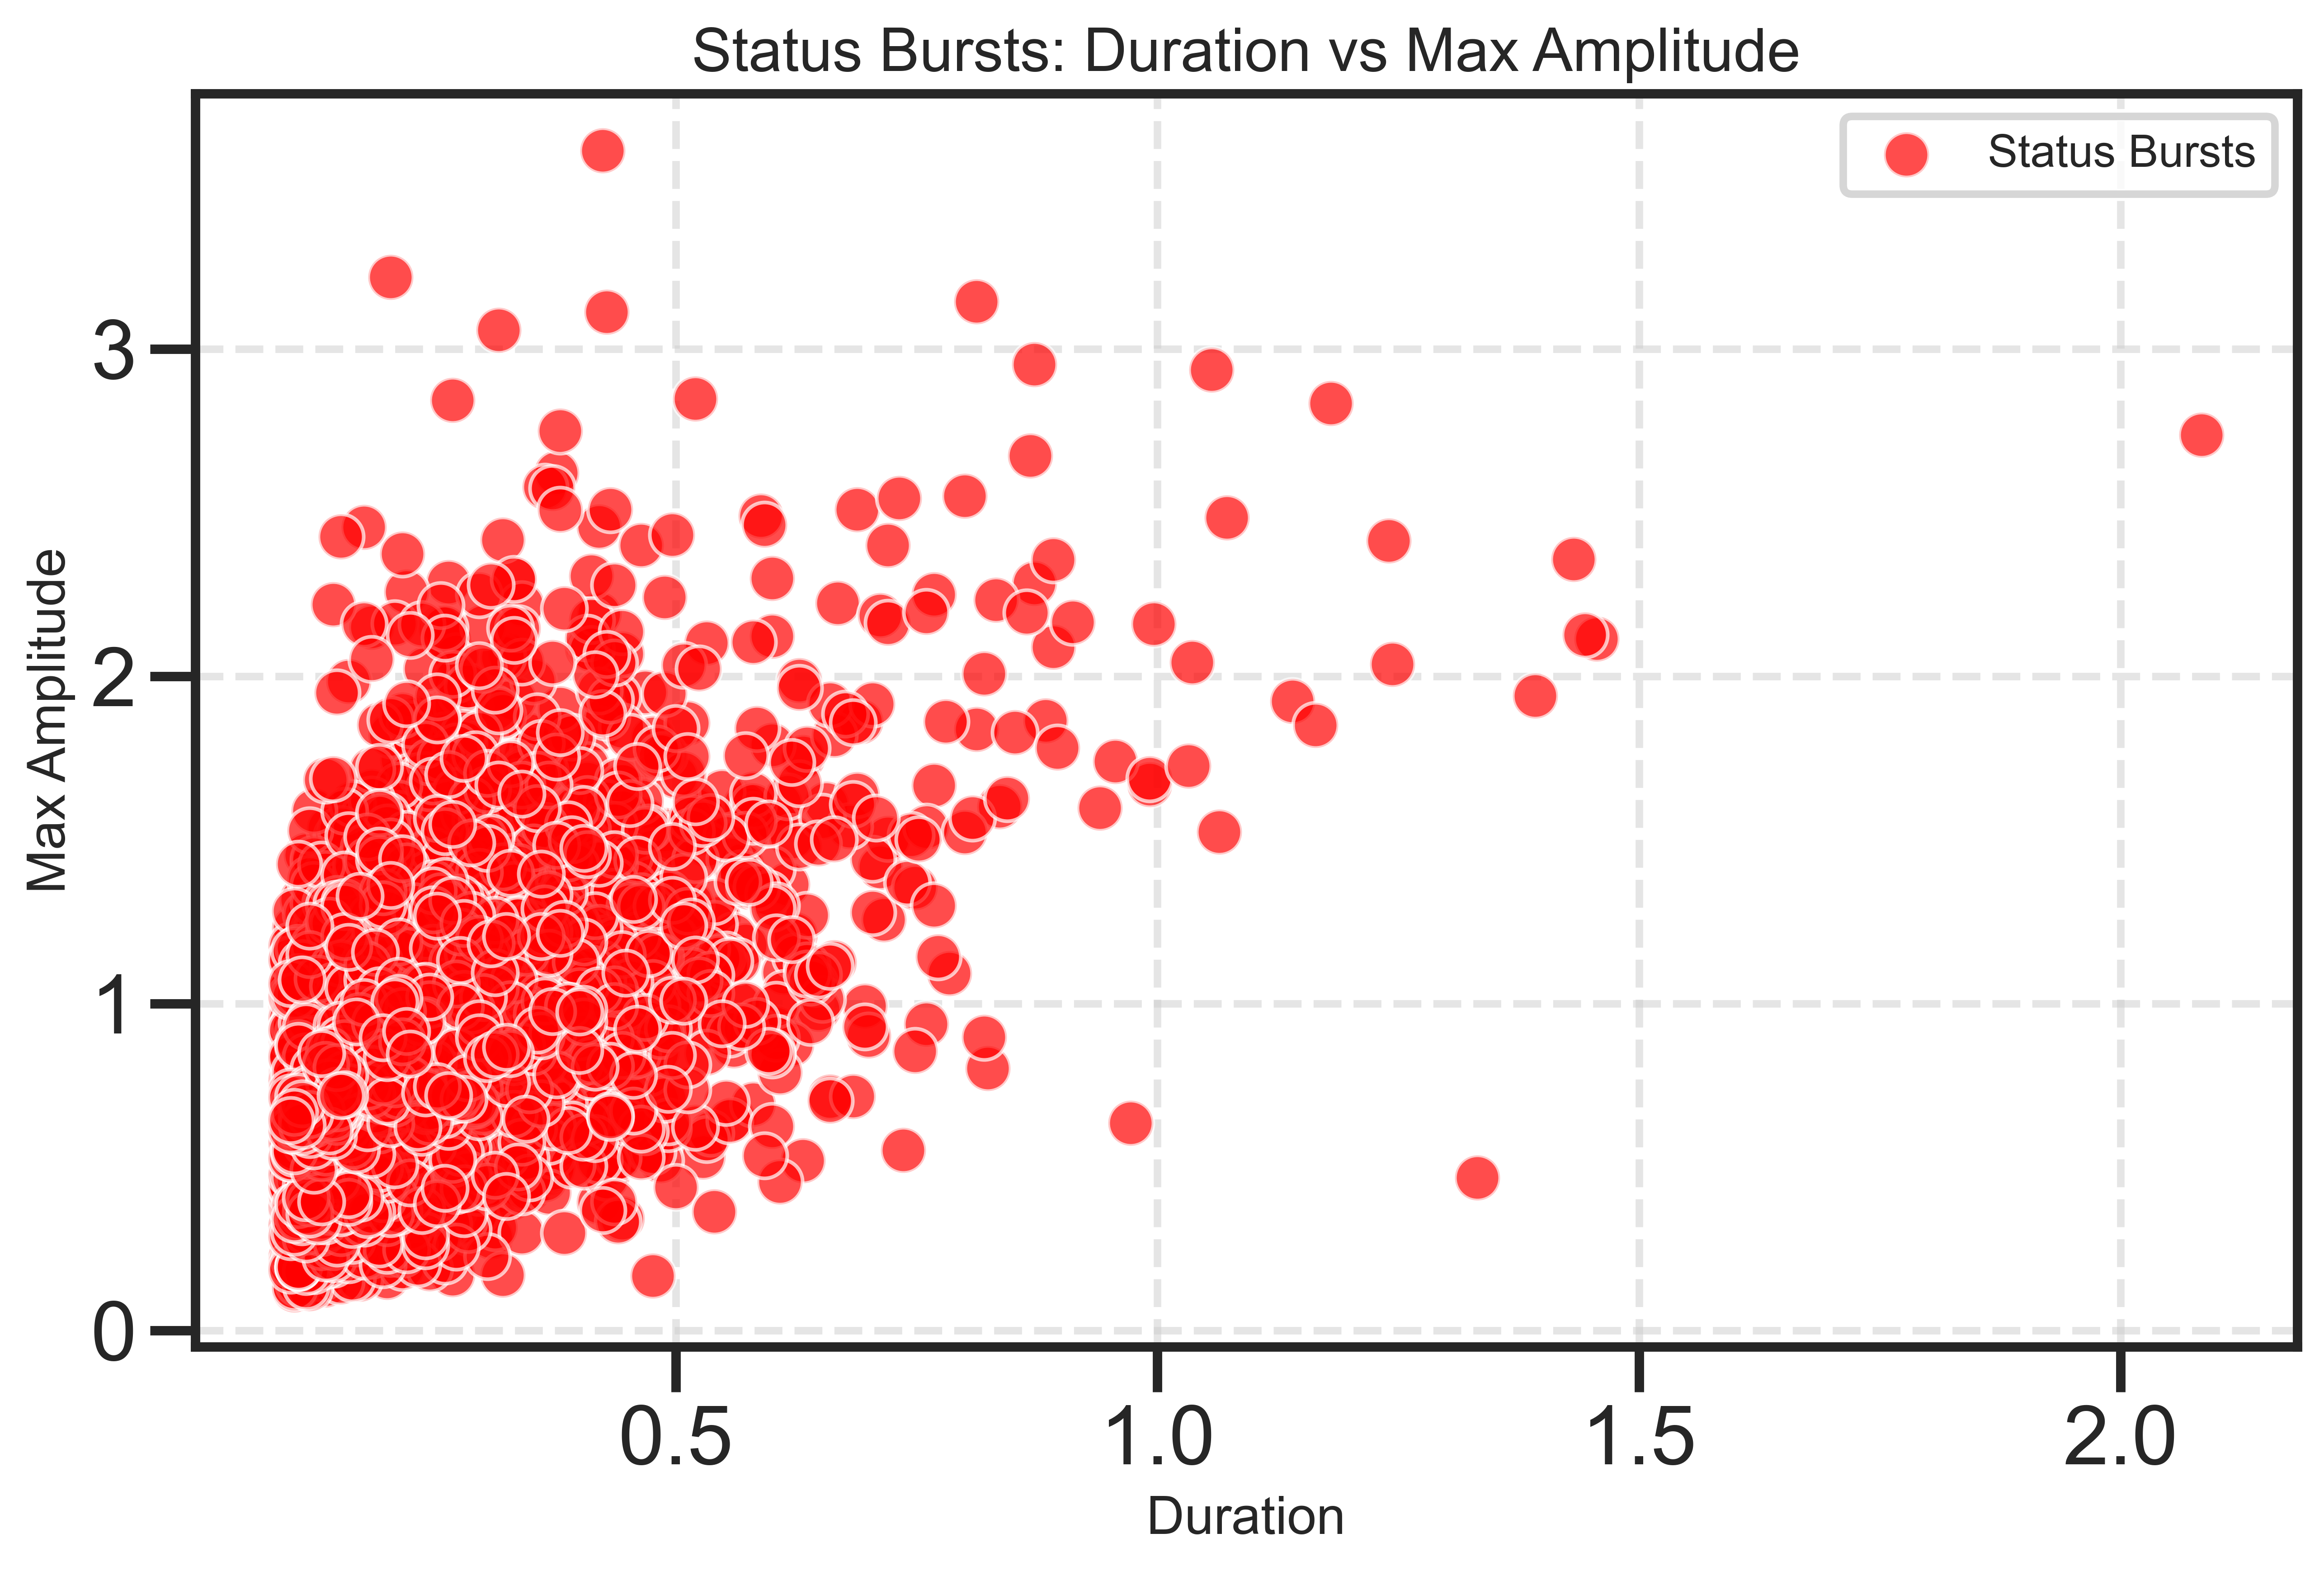

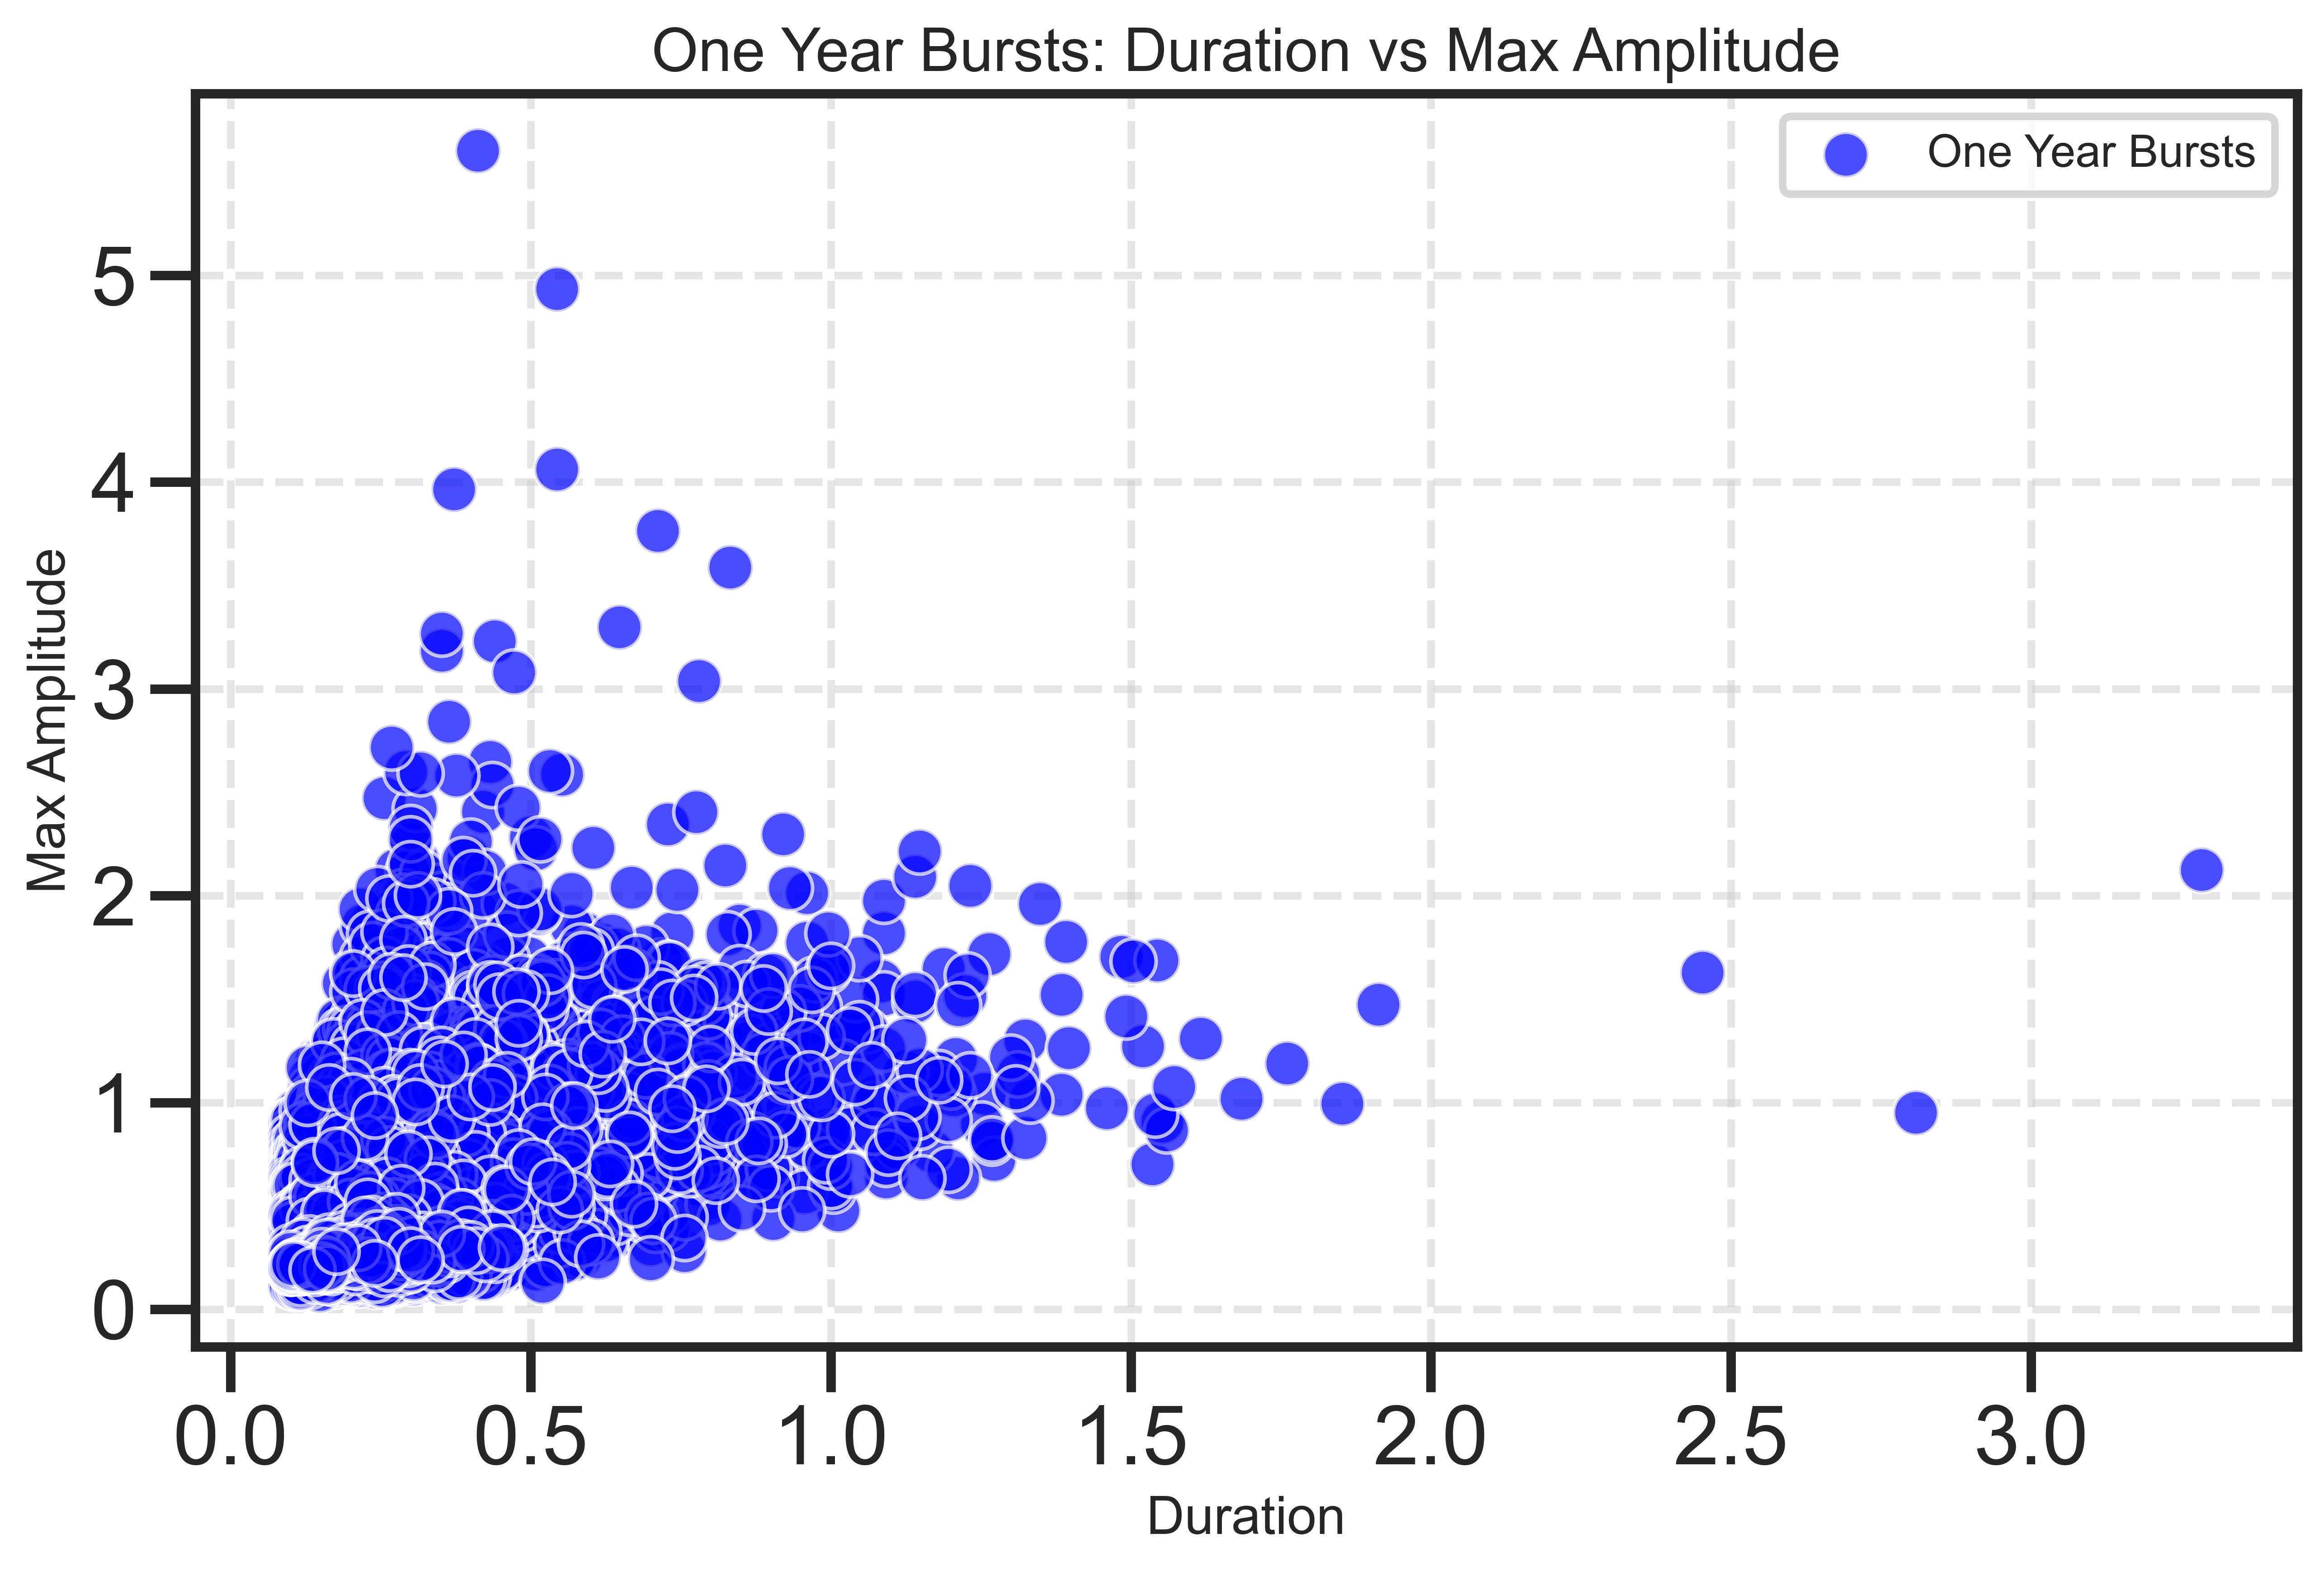

In [12]:
#INDIVIDUAL BURST PLOTS - AMPLITUDE VS DURATION IN SD & NON-SD
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for status bursts
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Duration', 
    y='MaxAmplitude', 
    data=status_bursts, 
    color='red', 
    alpha=0.7, 
    label='Status Bursts'
)
plt.title('Status Bursts: Duration vs Max Amplitude', fontsize=16)
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Max Amplitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

# Scatter plot for one year bursts
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Duration', 
    y='MaxAmplitude', 
    data=one_year_bursts, 
    color='blue', 
    alpha=0.7, 
    label='One Year Bursts'
)
plt.title('One Year Bursts: Duration vs Max Amplitude', fontsize=16)
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Max Amplitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()



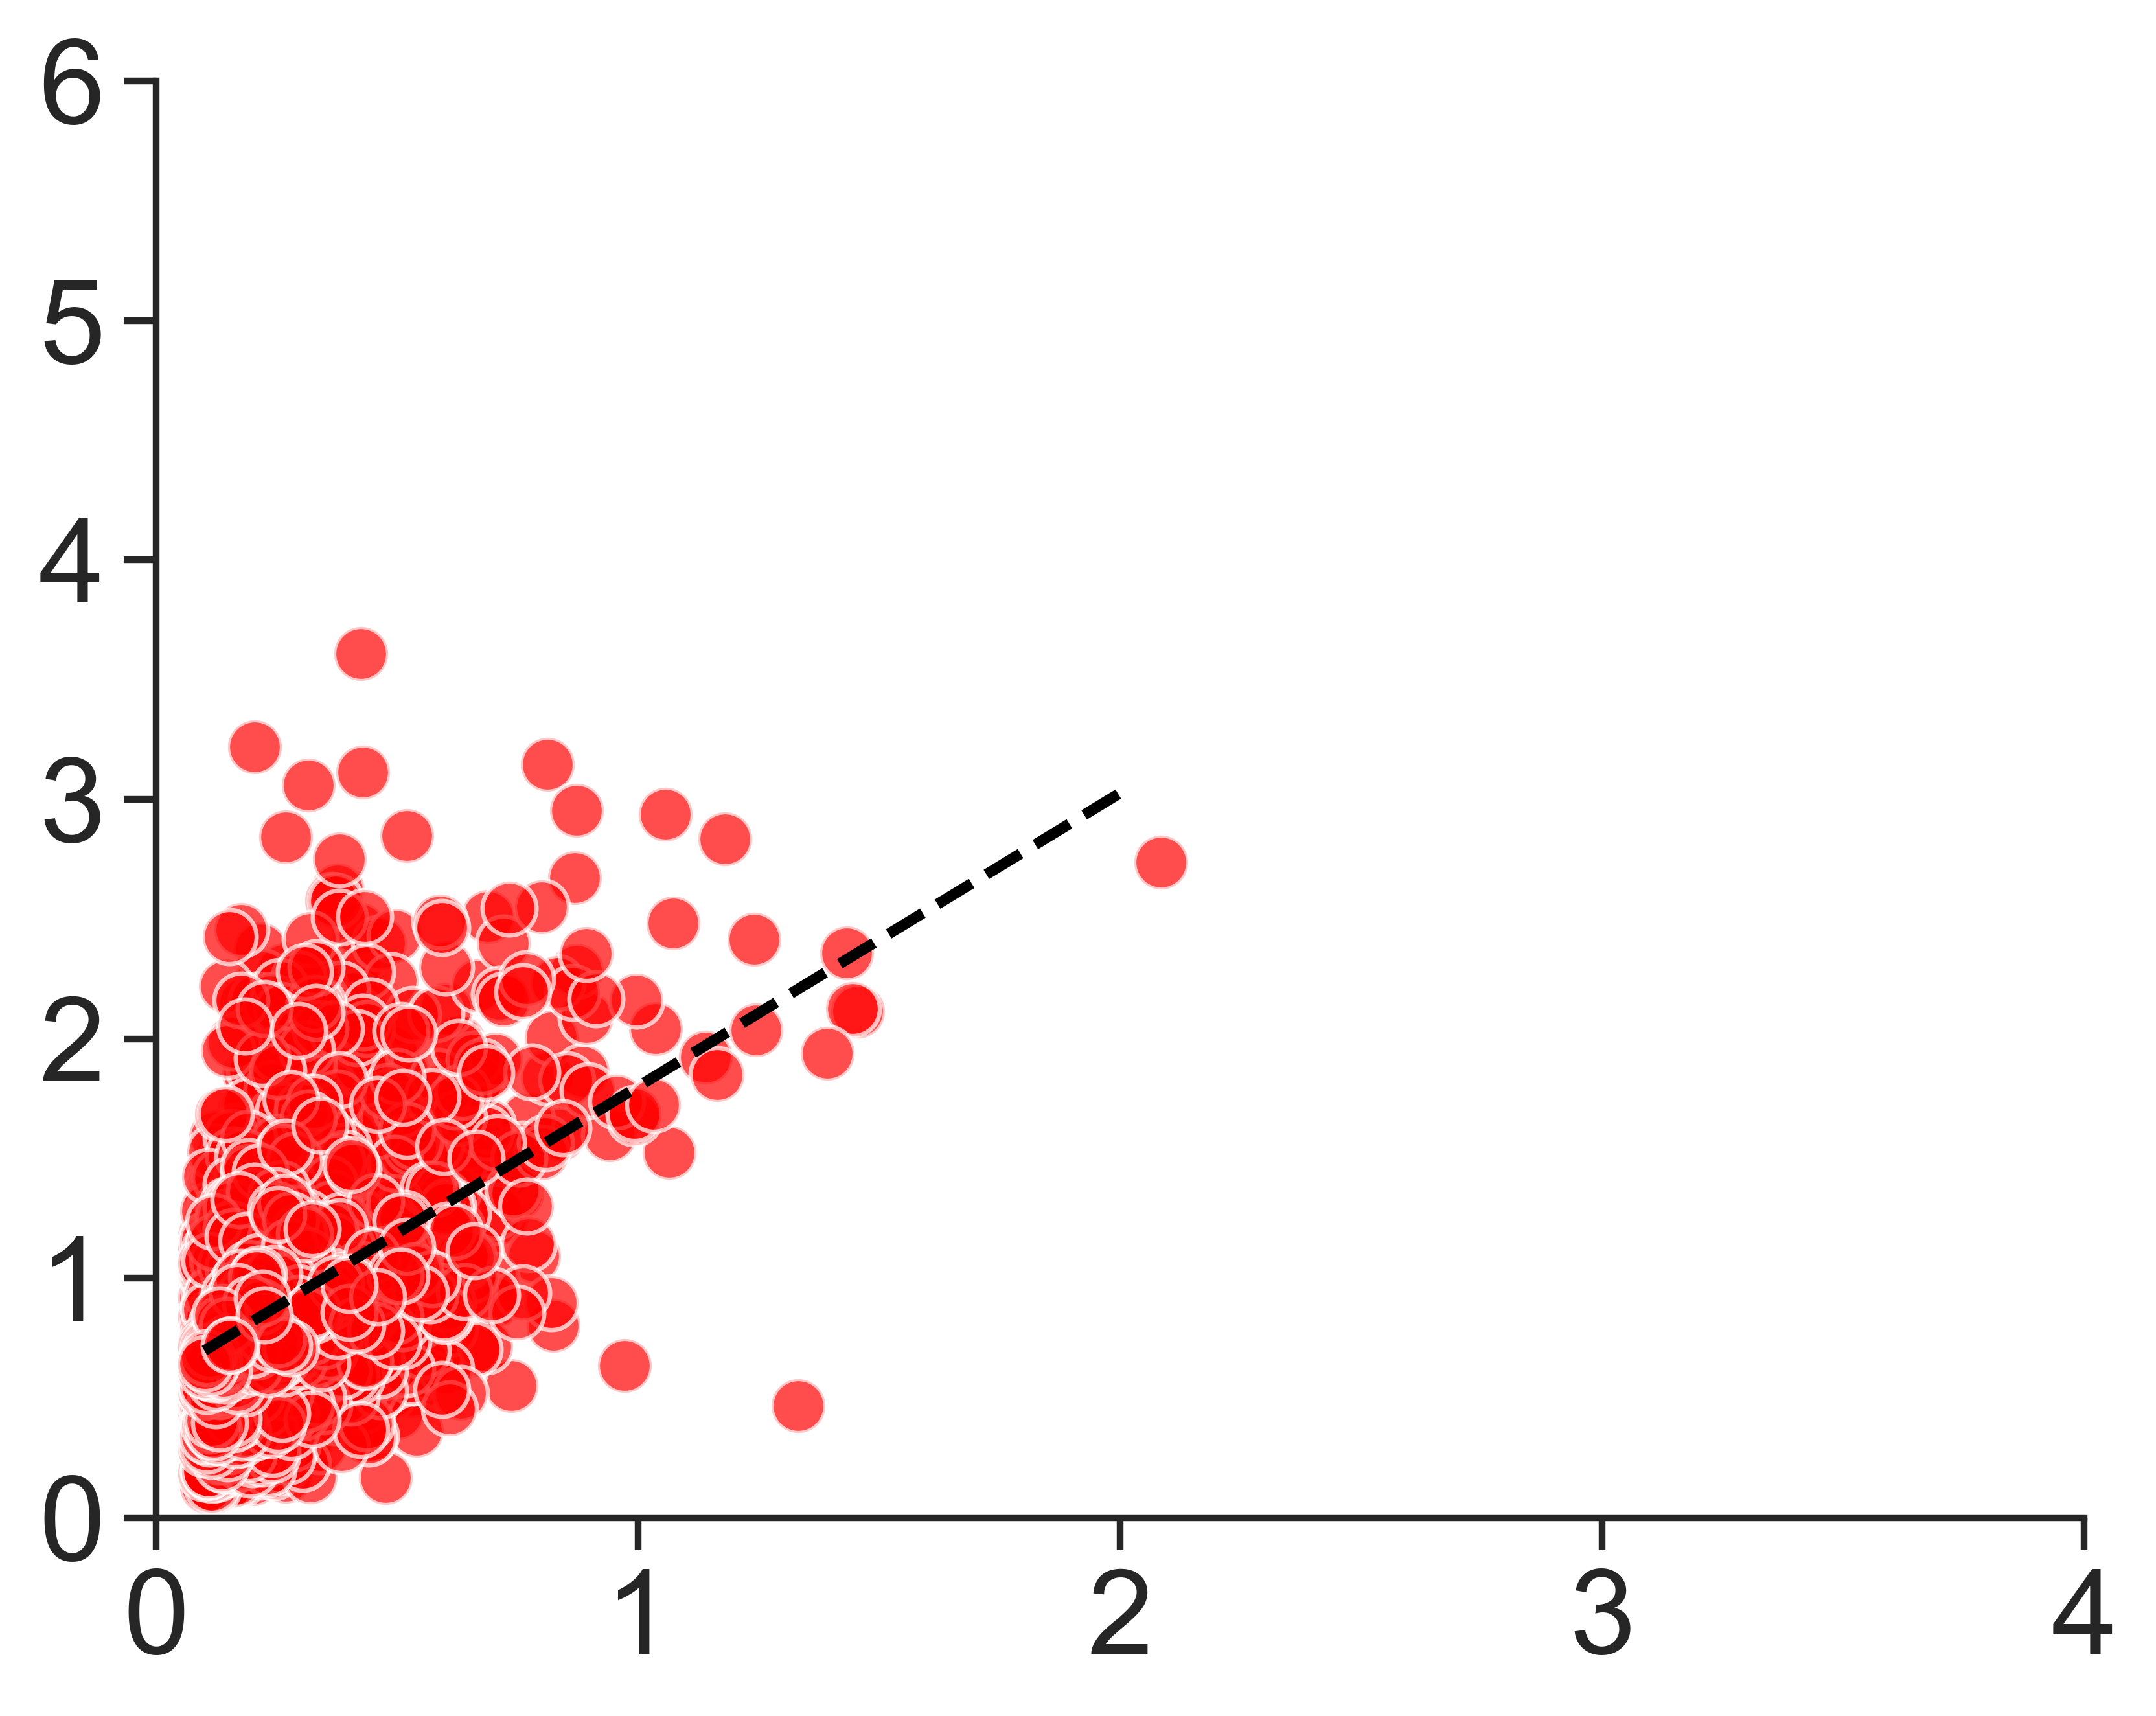

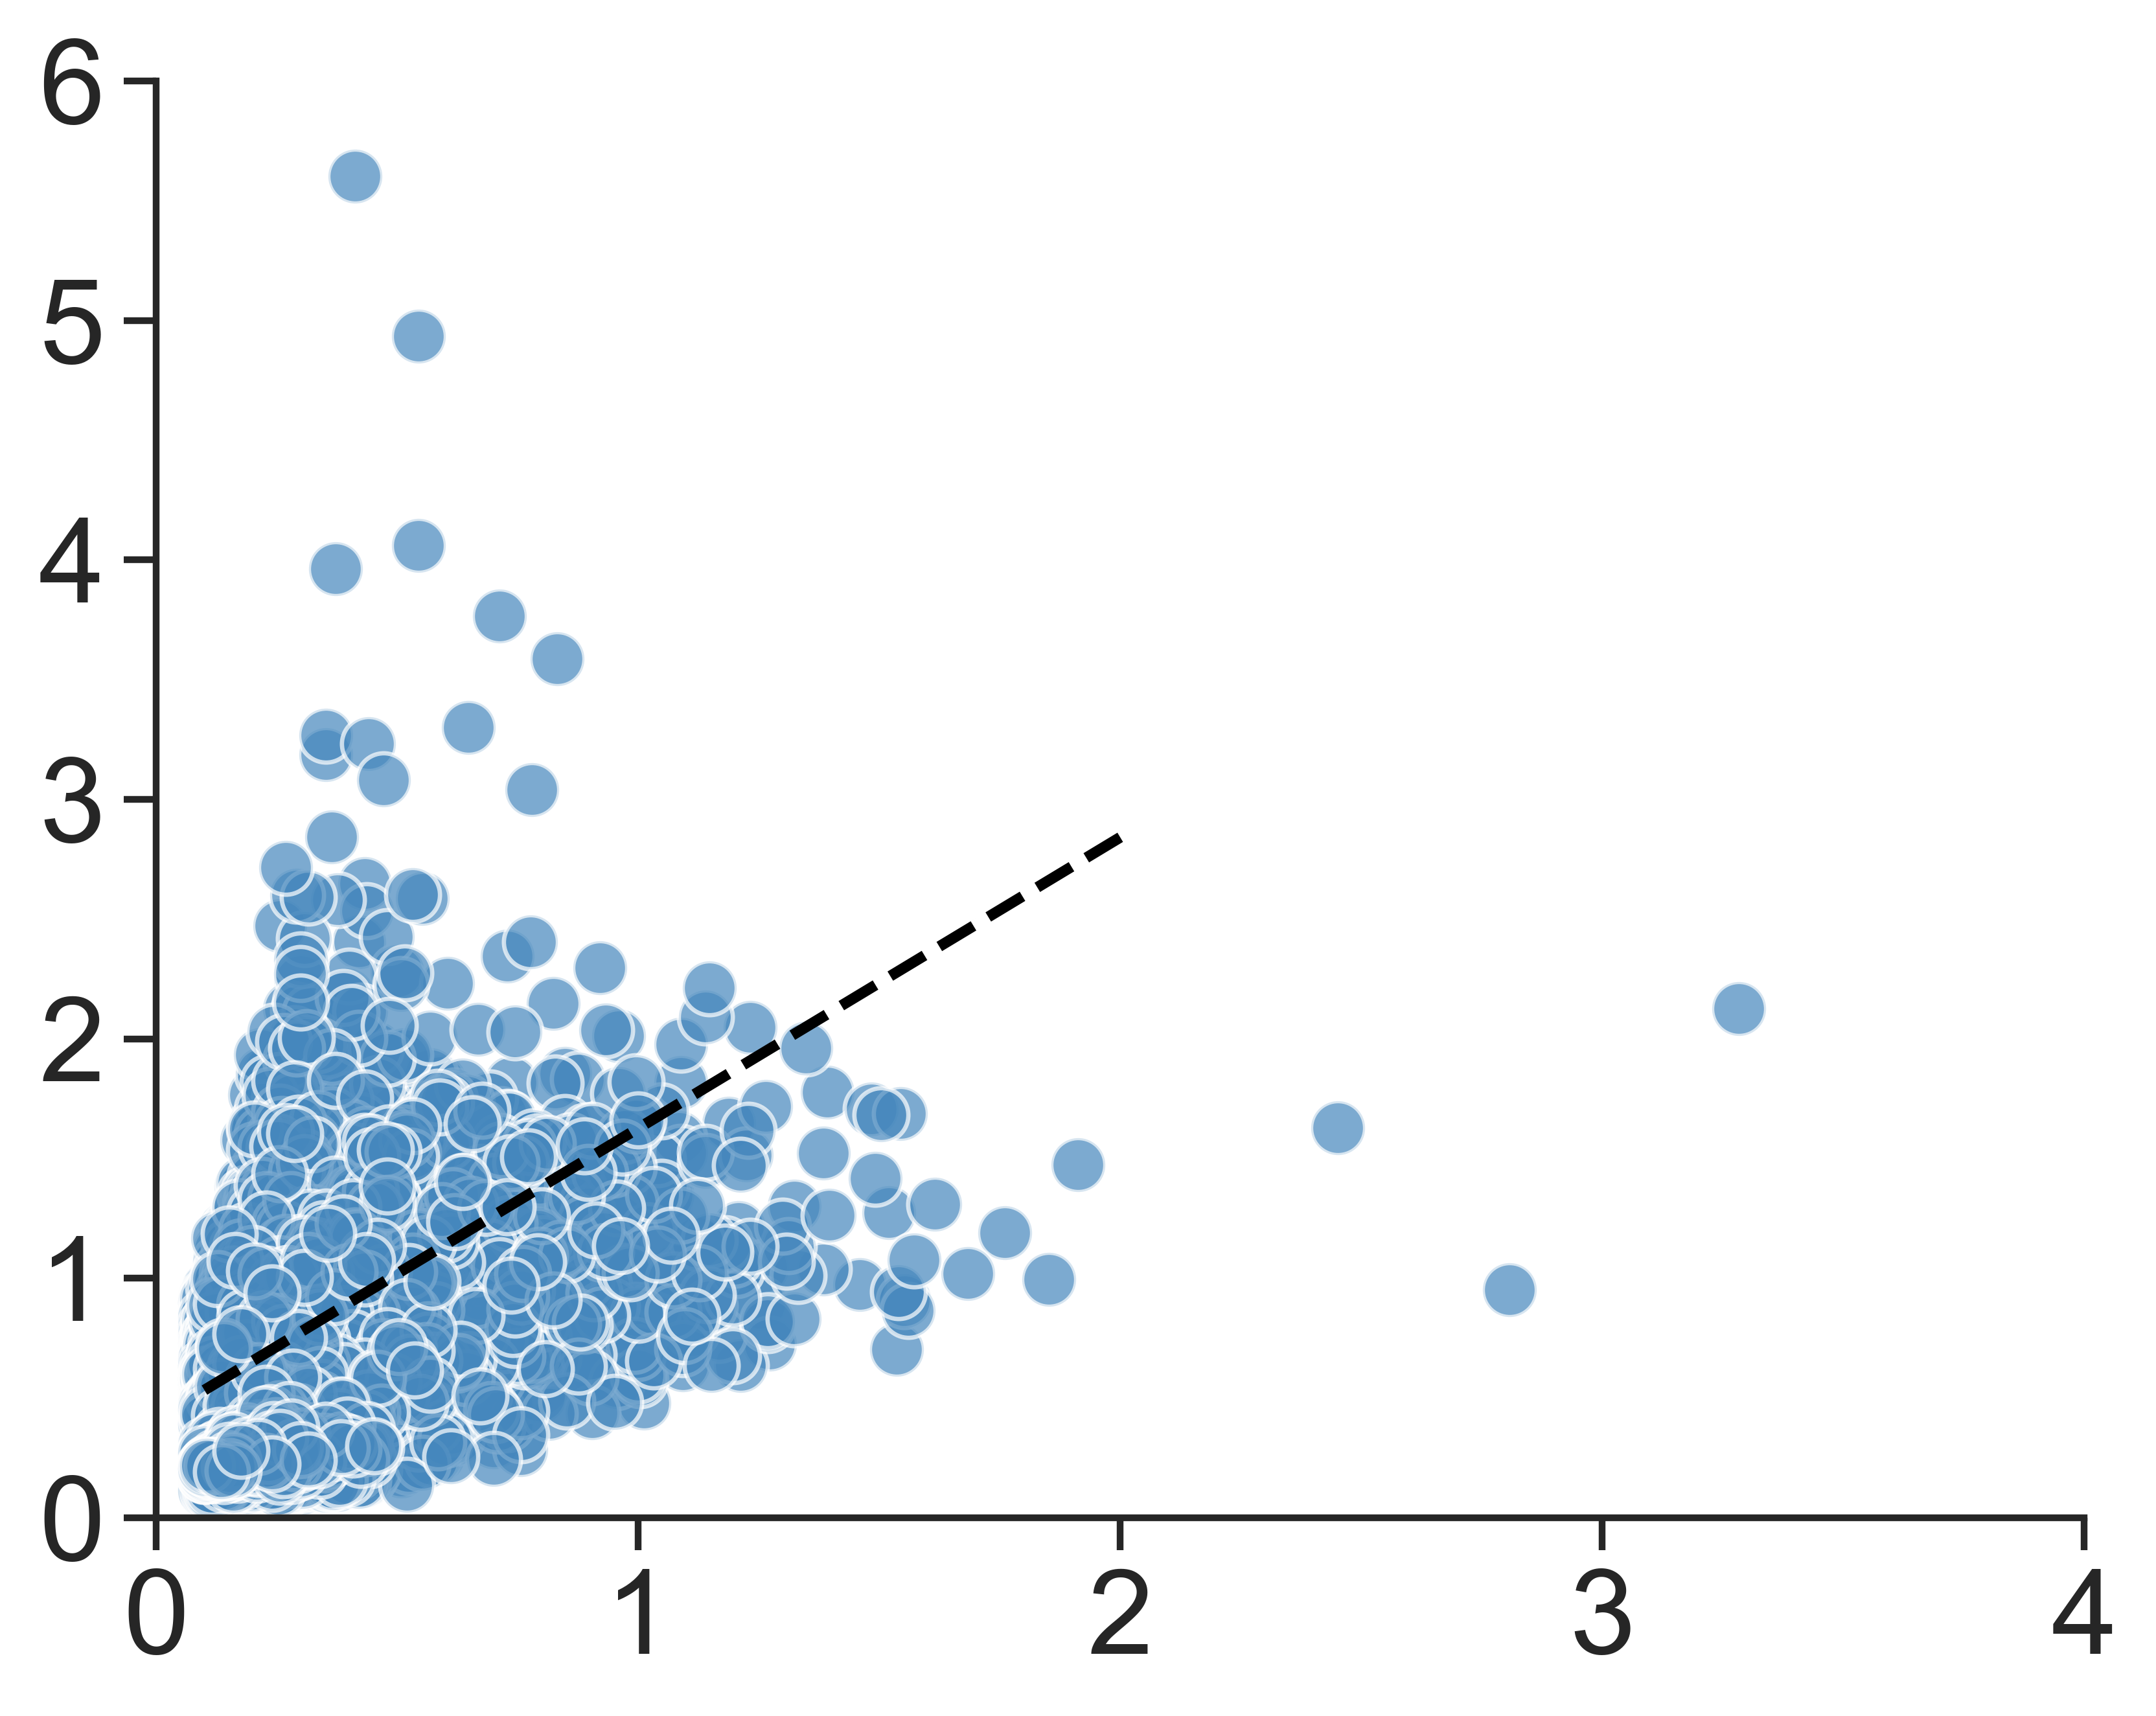

Mean Status Spearman Correlation: r = 0.5007
Mean One Year Spearman Correlation: r = 0.5231
Mean Status Slope: 1.2260, Mean Intercept: 0.5750
Mean One Year Slope: 1.2152, Mean Intercept: 0.4113
T-test for Slopes: t-statistic = 0.0461, p-value = 0.9639
T-test for Intercepts: t-statistic = 1.5984, p-value = 0.1308
T-test for Spearman r-values: t-statistic = -0.4076, p-value = 0.6893


In [13]:
#CALCULATE CORRELATION/SLOPE PER RECORDING, THEN AVERAGE ALL TO GET MEAN CORRELATION/SLOPE

from scipy.stats import spearmanr, linregress, ttest_ind, mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate slopes, intercepts, and Spearman correlation for each recording
def calculate_recording_stats(data):
    slopes = []
    intercepts = []
    spearman_r_values = []

    for patient in data['Patient'].unique():
        patient_data = data[data['Patient'] == patient]
        if len(patient_data) > 1:  # Ensure sufficient data for regression
            # Linear regression for slope and intercept
            slope, intercept, _, _, _ = linregress(patient_data['Duration'], patient_data['MaxAmplitude'])
            slopes.append(slope)
            intercepts.append(intercept)
            # Spearman correlation
            spearman_r, _ = spearmanr(patient_data['Duration'], patient_data['MaxAmplitude'])
            spearman_r_values.append(spearman_r)

    mean_slope = np.mean(slopes)
    mean_intercept = np.mean(intercepts)
    mean_spearman_r = np.mean(spearman_r_values)

    return mean_slope, mean_intercept, mean_spearman_r, slopes, intercepts, spearman_r_values

# Calculate stats for status and one-year bursts
status_stats = calculate_recording_stats(status_bursts)
one_year_stats = calculate_recording_stats(one_year_bursts)

mean_slope_status, mean_intercept_status, mean_spearman_status, slopes_status, intercepts_status, spearman_r_status = status_stats
mean_slope_one_year, mean_intercept_one_year, mean_spearman_one_year, slopes_one_year, intercepts_one_year, spearman_r_one_year = one_year_stats


sns.set_style("ticks")
#sns.set_context("talk")
sns.set_context("notebook", font_scale=2.0, rc={"lines.linewidth": 2.0})
# Scatter plot for status bursts with corrected fit line
ax1 = sns.scatterplot(
    x='Duration',
    y='MaxAmplitude',
    data=status_bursts,
    color='red',
    alpha=0.7,
    s=100,  # Increase dot size here
)
# Correct fit line using mean slope and intercept
#x_vals = np.linspace(status_bursts['Duration'].min(), status_bursts['Duration'].max(), 100)
x_vals = np.linspace(status_bursts['Duration'].min(), 2, 100)
y_vals = mean_slope_status * x_vals + mean_intercept_status
plt.plot(x_vals, y_vals, 'k--', label='Mean Fit (Status)')
ax1.set(xlabel=None)
ax1.set(ylabel=None)
plt.xlim(0, 4)
plt.ylim(0, 6)
sns.despine()
plt.show()

# Scatter plot for one year bursts with corrected fit line
ax2 = sns.scatterplot(
    x='Duration',
    y='MaxAmplitude',
    data=one_year_bursts,
    color='#4587BD',
    alpha=0.7,
    s=100,  # Increase dot size here
)
# Correct fit line using mean slope and intercept
#x_vals_one_year = np.linspace(one_year_bursts['Duration'].min(), one_year_bursts['Duration'].max(), 100)
x_vals_one_year = np.linspace(one_year_bursts['Duration'].min(), 2, 100)
y_vals_one_year = mean_slope_one_year * x_vals_one_year + mean_intercept_one_year
plt.plot(x_vals_one_year, y_vals_one_year, 'k--', label='Mean Fit (One Year)')
ax2.set(xlabel=None)
ax2.set(ylabel=None)
plt.xlim(0, 4)
plt.ylim(0, 6)
sns.despine()
plt.show()

# Compare slopes, intercepts, and r-values using appropriate tests
# Test for normality (if needed)
# T-tests for slopes and intercepts
slope_ttest = ttest_ind(slopes_status, slopes_one_year)
intercept_ttest = ttest_ind(intercepts_status, intercepts_one_year)
r_ttest = ttest_ind(spearman_r_status, spearman_r_one_year)

# Output results
print(f"Mean Status Spearman Correlation: r = {mean_spearman_status:.4f}")
print(f"Mean One Year Spearman Correlation: r = {mean_spearman_one_year:.4f}")
print(f"Mean Status Slope: {mean_slope_status:.4f}, Mean Intercept: {mean_intercept_status:.4f}")
print(f"Mean One Year Slope: {mean_slope_one_year:.4f}, Mean Intercept: {mean_intercept_one_year:.4f}")
print(f"T-test for Slopes: t-statistic = {slope_ttest.statistic:.4f}, p-value = {slope_ttest.pvalue:.4f}")
print(f"T-test for Intercepts: t-statistic = {intercept_ttest.statistic:.4f}, p-value = {intercept_ttest.pvalue:.4f}")
print(f"T-test for Spearman r-values: t-statistic = {r_ttest.statistic:.4f}, p-value = {r_ttest.pvalue:.4f}")



In [15]:
#GLM Mixed Effects Model
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Add a unique identifier for each burst
combined_data['BurstID'] = combined_data.index  # Assuming index uniquely identifies bursts

# Fit a mixed-effects model
# Random intercepts and slopes for each BurstID
model_mixed = smf.mixedlm("MaxAmplitude ~ Duration * Group", 
                          data=combined_data, 
                          groups=combined_data["BurstID"], 
                          re_formula="~Duration").fit()

# Print the model summary
print(model_mixed.summary())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Libra

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    MaxAmplitude
No. Observations:    23667      Method:                REML        
No. Groups:          23667      Scale:                 0.0456      
Min. group size:     1          Log-Likelihood:        -3946.0495  
Max. group size:     1          Converged:             No          
Mean group size:     1.0                                           
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.353    0.005 64.301 0.000  0.342  0.363
Group[T.Status]           0.136    0.009 14.503 0.000  0.118  0.154
Duration                  1.269    0.029 44.348 0.000  1.213  1.325
Duration:Group[T.Status]  0.484    0.049  9.912 0.000  0.389  0.580
Group Var                 0.000                                